In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

Seed set to 42


In [5]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


## Parameters

In [8]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [10]:
load_molecule_pairs_file= True
only_use_gnps=False

In [11]:
## Load spectrum using spectrumutils

In [12]:
config=Config()

## Load data from matchms

In [13]:
all_spectrums_gnps_MATCHMS = [(s) for s in load_from_mgf(gnps_path)]

In [14]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-02-23 09:27:52,211:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,213:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,213:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,214:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,215:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,215:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,216:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,217:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,217:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,218:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,219:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-23 09:27:52,219:WARNING:matchms:add

In [15]:
#all_spectrums_nist_MATCHMS = list(itertools.islice(load_from_msp(nist_path), 30000))
all_spectrums_nist_MATCHMS = [s for s in load_from_msp(nist_path)]

In [16]:
len(all_spectrums_gnps_MATCHMS),len(all_spectrums_janssen_MATCHMS),len(all_spectrums_nist_MATCHMS)

(504840, 2546, 1026712)

In [17]:
all_spectrums_MATCHMS = all_spectrums_gnps_MATCHMS + all_spectrums_janssen_MATCHMS + all_spectrums_nist_MATCHMS

## Load molecular pairs

In [18]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
        original_molecule_pairs= dataset['uniformed_molecule_pairs_test']
else:
        number_pairs=10000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [19]:
len(original_molecule_pairs)

185165

In [20]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
else:
    molecule_pairs=original_molecule_pairs

In [21]:
len(molecule_pairs)

185165

## get the hash indexes in the original datasets

In [22]:
hash_gnps_MATCHMS = [s.spectrum_hash() for s in all_spectrums_gnps_MATCHMS]

In [23]:
hash_janssen_MATCHMS = [s.spectrum_hash() for s in all_spectrums_janssen_MATCHMS]

In [24]:
hash_nist_MATCHMS = [s.spectrum_hash() for s in all_spectrums_nist_MATCHMS]

In [25]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash() for s in all_spectrums_MATCHMS]

In [26]:
unique_hashes_in_molecule_pairs= np.unique([m.spectrum_object_0.spectrum_hash for m in original_molecule_pairs]+[m.spectrum_object_1.spectrum_hash for m in original_molecule_pairs])

In [27]:
# spectrums that are used in my dataset
spectrums_match_hash= [(s,t) for s,t in zip(all_spectrums_MATCHMS, target_hashes) if (t in unique_hashes_in_molecule_pairs)]

In [28]:
original_spectrum_match_hash= [p[0] for p in spectrums_match_hash]
target_hashes_subset = [p[1] for p in spectrums_match_hash]

In [29]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    original_spectrum_match_hash[i] = add_fingerprint(original_spectrum_match_hash[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32069/32069 [00:21<00:00, 1470.46it/s]


## Preprocessing data for spec2vec

In [30]:
preprocessed_spectrums = original_spectrum_match_hash.copy()

In [31]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    preprocessed_spectrums[i] = Spec2VecComparison.spectrum_processing(original_spectrum_match_hash[i])

 21%|██████████████████████████████████▊                                                                                                                                      | 6615/32069 [00:11<00:41, 610.77it/s]

2024-02-23 09:36:37,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,593:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|███████████████████████████████████▏                                                                                                                                     | 6684/32069 [00:11<00:40, 633.48it/s]

2024-02-23 09:36:37,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|███████████████████████████████████▌                                                                                                                                     | 6756/32069 [00:11<00:38, 657.45it/s]

2024-02-23 09:36:37,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|███████████████████████████████████▉                                                                                                                                     | 6830/32069 [00:11<00:37, 681.63it/s]

2024-02-23 09:36:37,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,859:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,863:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|████████████████████████████████████▎                                                                                                                                    | 6902/32069 [00:11<00:36, 691.65it/s]

2024-02-23 09:36:37,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:37,962:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:37,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|████████████████████████████████████▋                                                                                                                                    | 6972/32069 [00:11<00:39, 638.89it/s]

2024-02-23 09:36:38,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,091:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████                                                                                                                                    | 7041/32069 [00:11<00:38, 653.04it/s]

2024-02-23 09:36:38,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,190:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,193:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████▍                                                                                                                                   | 7107/32069 [00:11<00:40, 623.21it/s]

2024-02-23 09:36:38,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,307:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████▊                                                                                                                                   | 7180/32069 [00:12<00:38, 652.90it/s]

2024-02-23 09:36:38,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,408:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,408:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|██████████████████████████████████████▏                                                                                                                                  | 7254/32069 [00:12<00:36, 676.40it/s]

2024-02-23 09:36:38,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,507:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,508:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,508:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,548:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|██████████████████████████████████████▌                                                                                                                                  | 7323/32069 [00:12<00:39, 627.97it/s]

2024-02-23 09:36:38,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|██████████████████████████████████████▉                                                                                                                                  | 7395/32069 [00:12<00:37, 652.95it/s]

2024-02-23 09:36:38,737:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,742:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|███████████████████████████████████████▎                                                                                                                                 | 7462/32069 [00:12<00:41, 596.01it/s]

2024-02-23 09:36:38,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,876:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,876:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|███████████████████████████████████████▋                                                                                                                                 | 7524/32069 [00:12<00:40, 601.62it/s]

2024-02-23 09:36:38,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,975:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:38,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:38,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|███████████████████████████████████████▉                                                                                                                                 | 7588/32069 [00:12<00:42, 569.88it/s]

2024-02-23 09:36:39,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,104:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▎                                                                                                                                | 7658/32069 [00:12<00:40, 599.08it/s]

2024-02-23 09:36:39,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,219:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▋                                                                                                                                | 7719/32069 [00:13<00:52, 460.29it/s]

2024-02-23 09:36:39,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,417:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▉                                                                                                                                | 7771/32069 [00:13<01:02, 386.09it/s]

2024-02-23 09:36:39,615:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,615:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|█████████████████████████████████████████▏                                                                                                                               | 7815/32069 [00:13<01:08, 355.94it/s]

2024-02-23 09:36:39,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,775:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,780:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,780:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|█████████████████████████████████████████▍                                                                                                                               | 7855/32069 [00:13<01:14, 323.63it/s]

2024-02-23 09:36:39,931:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,931:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:39,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:39,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▌                                                                                                                               | 7890/32069 [00:13<01:16, 314.24it/s]

2024-02-23 09:36:40,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,055:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▊                                                                                                                               | 7923/32069 [00:13<01:21, 295.75it/s]

2024-02-23 09:36:40,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,192:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▉                                                                                                                               | 7955/32069 [00:13<01:20, 298.74it/s]

2024-02-23 09:36:40,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,297:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,297:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████                                                                                                                               | 7986/32069 [00:14<01:25, 280.40it/s]

2024-02-23 09:36:40,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,429:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▏                                                                                                                              | 8015/32069 [00:14<01:32, 260.00it/s]

2024-02-23 09:36:40,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,569:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▍                                                                                                                              | 8042/32069 [00:14<01:34, 254.03it/s]

2024-02-23 09:36:40,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,670:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,675:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▌                                                                                                                              | 8068/32069 [00:14<01:34, 254.69it/s]

2024-02-23 09:36:40,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▋                                                                                                                              | 8094/32069 [00:14<01:42, 234.12it/s]

2024-02-23 09:36:40,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,913:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,917:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:40,918:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:40,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▊                                                                                                                              | 8118/32069 [00:14<01:43, 231.53it/s]

2024-02-23 09:36:41,014:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,015:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▉                                                                                                                              | 8143/32069 [00:14<01:41, 235.50it/s]

2024-02-23 09:36:41,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,115:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|███████████████████████████████████████████                                                                                                                              | 8168/32069 [00:14<01:40, 237.48it/s]

2024-02-23 09:36:41,219:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,225:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,232:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,237:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▏                                                                                                                             | 8192/32069 [00:15<01:49, 218.92it/s]

2024-02-23 09:36:41,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,357:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,357:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▎                                                                                                                             | 8218/32069 [00:15<01:44, 228.97it/s]

2024-02-23 09:36:41,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▍                                                                                                                             | 8242/32069 [00:15<01:42, 231.98it/s]

2024-02-23 09:36:41,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,551:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▌                                                                                                                             | 8267/32069 [00:15<01:40, 236.96it/s]

2024-02-23 09:36:41,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,651:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▋                                                                                                                             | 8293/32069 [00:15<01:37, 243.53it/s]

2024-02-23 09:36:41,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▊                                                                                                                             | 8323/32069 [00:15<01:31, 259.00it/s]

2024-02-23 09:36:41,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,857:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,857:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████                                                                                                                             | 8350/32069 [00:15<01:31, 259.22it/s]

2024-02-23 09:36:41,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:41,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:41,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▏                                                                                                                            | 8378/32069 [00:15<01:29, 264.61it/s]

2024-02-23 09:36:42,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,060:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▎                                                                                                                            | 8412/32069 [00:15<01:23, 284.57it/s]

2024-02-23 09:36:42,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▍                                                                                                                            | 8444/32069 [00:15<01:20, 294.12it/s]

2024-02-23 09:36:42,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,262:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,269:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,269:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▋                                                                                                                            | 8474/32069 [00:16<01:22, 284.47it/s]

2024-02-23 09:36:42,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,380:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|████████████████████████████████████████████▊                                                                                                                            | 8504/32069 [00:16<01:22, 286.88it/s]

2024-02-23 09:36:42,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,477:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,480:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,480:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,482:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,482:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|████████████████████████████████████████████▉                                                                                                                            | 8539/32069 [00:16<01:17, 304.72it/s]

2024-02-23 09:36:42,578:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,578:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,581:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,582:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,585:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,585:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▏                                                                                                                           | 8573/32069 [00:16<01:18, 300.39it/s]

2024-02-23 09:36:42,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,699:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▎                                                                                                                           | 8604/32069 [00:16<01:18, 300.68it/s]

2024-02-23 09:36:42,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▌                                                                                                                           | 8639/32069 [00:16<01:14, 314.06it/s]

2024-02-23 09:36:42,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,898:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,902:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:42,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▋                                                                                                                           | 8671/32069 [00:16<01:14, 315.22it/s]

2024-02-23 09:36:42,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:42,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,002:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,002:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,006:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▊                                                                                                                           | 8703/32069 [00:16<01:20, 288.71it/s]

2024-02-23 09:36:43,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,135:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,139:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████                                                                                                                           | 8733/32069 [00:16<01:22, 281.17it/s]

2024-02-23 09:36:43,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,254:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▏                                                                                                                          | 8762/32069 [00:17<01:30, 256.56it/s]

2024-02-23 09:36:43,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▎                                                                                                                          | 8789/32069 [00:17<01:52, 207.75it/s]

2024-02-23 09:36:43,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▍                                                                                                                          | 8812/32069 [00:17<02:07, 182.51it/s]

2024-02-23 09:36:43,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,766:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8832/32069 [00:17<02:16, 170.35it/s]

2024-02-23 09:36:43,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,899:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:43,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:43,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▋                                                                                                                          | 8851/32069 [00:17<02:16, 170.09it/s]

2024-02-23 09:36:44,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,021:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,021:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▊                                                                                                                          | 8873/32069 [00:17<02:09, 179.00it/s]

2024-02-23 09:36:44,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,129:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▊                                                                                                                          | 8892/32069 [00:17<02:13, 173.84it/s]

2024-02-23 09:36:44,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,239:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▉                                                                                                                          | 8910/32069 [00:17<02:15, 170.72it/s]

2024-02-23 09:36:44,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,346:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████                                                                                                                          | 8928/32069 [00:18<02:17, 168.06it/s]

2024-02-23 09:36:44,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8946/32069 [00:18<02:15, 170.64it/s]

2024-02-23 09:36:44,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,556:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8964/32069 [00:18<02:19, 165.72it/s]

2024-02-23 09:36:44,674:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,674:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,686:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▎                                                                                                                         | 8989/32069 [00:18<02:02, 187.96it/s]

2024-02-23 09:36:44,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,780:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▌                                                                                                                         | 9022/32069 [00:18<01:42, 225.87it/s]

2024-02-23 09:36:44,876:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,876:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,879:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▋                                                                                                                         | 9052/32069 [00:18<01:34, 243.25it/s]

2024-02-23 09:36:44,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,983:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,987:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:44,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:44,993:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▊                                                                                                                         | 9079/32069 [00:18<01:31, 250.16it/s]

2024-02-23 09:36:45,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▉                                                                                                                         | 9105/32069 [00:18<01:36, 237.00it/s]

2024-02-23 09:36:45,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,218:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,221:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|████████████████████████████████████████████████▏                                                                                                                        | 9137/32069 [00:18<01:28, 258.05it/s]

2024-02-23 09:36:45,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,311:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,314:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▎                                                                                                                        | 9166/32069 [00:19<01:26, 265.60it/s]

2024-02-23 09:36:45,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▍                                                                                                                        | 9193/32069 [00:19<01:33, 245.82it/s]

2024-02-23 09:36:45,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,551:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▌                                                                                                                        | 9219/32069 [00:19<01:44, 218.03it/s]

2024-02-23 09:36:45,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,703:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▋                                                                                                                        | 9244/32069 [00:19<01:41, 224.59it/s]

2024-02-23 09:36:45,798:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,811:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▊                                                                                                                        | 9268/32069 [00:19<01:51, 203.90it/s]

2024-02-23 09:36:45,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,944:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:45,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:45,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▉                                                                                                                        | 9290/32069 [00:19<01:51, 205.19it/s]

2024-02-23 09:36:46,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,048:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,051:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,054:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,054:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████                                                                                                                        | 9315/32069 [00:19<01:45, 215.19it/s]

2024-02-23 09:36:46,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,155:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,159:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▏                                                                                                                       | 9339/32069 [00:19<01:43, 220.51it/s]

2024-02-23 09:36:46,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,254:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,259:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▎                                                                                                                       | 9366/32069 [00:20<01:37, 232.90it/s]

2024-02-23 09:36:46,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,357:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,362:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,366:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▌                                                                                                                       | 9394/32069 [00:20<01:32, 244.81it/s]

2024-02-23 09:36:46,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▋                                                                                                                       | 9419/32069 [00:20<01:37, 231.71it/s]

2024-02-23 09:36:46,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,598:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▊                                                                                                                       | 9443/32069 [00:20<01:46, 212.07it/s]

2024-02-23 09:36:46,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,719:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 9465/32069 [00:20<01:47, 210.60it/s]

2024-02-23 09:36:46,824:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,824:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,833:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████                                                                                                                       | 9489/32069 [00:20<01:43, 217.70it/s]

2024-02-23 09:36:46,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,932:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,940:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:46,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:46,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▏                                                                                                                      | 9512/32069 [00:20<01:54, 196.92it/s]

2024-02-23 09:36:47,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,075:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9539/32069 [00:20<01:44, 215.74it/s]

2024-02-23 09:36:47,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9563/32069 [00:20<01:43, 218.26it/s]

2024-02-23 09:36:47,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9586/32069 [00:21<01:53, 197.88it/s]

2024-02-23 09:36:47,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,429:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9613/32069 [00:21<01:44, 215.72it/s]

2024-02-23 09:36:47,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,521:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,526:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9645/32069 [00:21<01:32, 242.93it/s]

2024-02-23 09:36:47,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,624:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,629:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,629:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,634:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,634:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9671/32069 [00:21<01:40, 223.34it/s]

2024-02-23 09:36:47,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████                                                                                                                      | 9697/32069 [00:21<01:36, 230.73it/s]

2024-02-23 09:36:47,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:47,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9721/32069 [00:21<01:43, 215.70it/s]

2024-02-23 09:36:47,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:47,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,003:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,010:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9744/32069 [00:21<01:57, 190.44it/s]

2024-02-23 09:36:48,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,159:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,159:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▌                                                                                                                     | 9775/32069 [00:21<01:41, 219.61it/s]

2024-02-23 09:36:48,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,254:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,264:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9811/32069 [00:22<01:26, 255.87it/s]

2024-02-23 09:36:48,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,362:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9841/32069 [00:22<01:23, 266.62it/s]

2024-02-23 09:36:48,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████                                                                                                                     | 9871/32069 [00:22<01:20, 274.52it/s]

2024-02-23 09:36:48,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9900/32069 [00:22<01:28, 249.66it/s]

2024-02-23 09:36:48,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,707:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,714:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,714:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,722:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9926/32069 [00:22<01:40, 220.00it/s]

2024-02-23 09:36:48,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,859:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9953/32069 [00:22<01:35, 231.74it/s]

2024-02-23 09:36:48,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:48,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:48,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9986/32069 [00:22<01:25, 257.38it/s]

2024-02-23 09:36:49,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▍                                                                                                                   | 10019/32069 [00:22<01:19, 276.11it/s]

2024-02-23 09:36:49,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,168:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,168:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▋                                                                                                                   | 10049/32069 [00:22<01:18, 281.94it/s]

2024-02-23 09:36:49,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,262:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,264:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▊                                                                                                                   | 10078/32069 [00:23<01:17, 282.46it/s]

2024-02-23 09:36:49,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,360:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,362:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,362:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|████████████████████████████████████████████████████▉                                                                                                                   | 10107/32069 [00:23<01:17, 283.76it/s]

2024-02-23 09:36:49,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,466:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,470:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,470:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▏                                                                                                                  | 10142/32069 [00:23<01:12, 302.49it/s]

2024-02-23 09:36:49,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,569:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,571:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▎                                                                                                                  | 10173/32069 [00:23<01:12, 302.26it/s]

2024-02-23 09:36:49,665:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,665:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,674:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,674:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▍                                                                                                                  | 10204/32069 [00:23<01:13, 299.26it/s]

2024-02-23 09:36:49,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,781:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▌                                                                                                                  | 10235/32069 [00:23<01:28, 247.95it/s]

2024-02-23 09:36:49,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,946:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:49,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:49,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 10263/32069 [00:23<01:25, 254.53it/s]

2024-02-23 09:36:50,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,048:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,050:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,051:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▉                                                                                                                  | 10290/32069 [00:23<01:26, 252.41it/s]

2024-02-23 09:36:50,159:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,159:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,168:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████                                                                                                                  | 10317/32069 [00:23<01:27, 247.97it/s]

2024-02-23 09:36:50,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,273:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,277:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,281:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▏                                                                                                                 | 10343/32069 [00:24<01:33, 231.98it/s]

2024-02-23 09:36:50,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,415:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▎                                                                                                                 | 10367/32069 [00:24<01:34, 230.34it/s]

2024-02-23 09:36:50,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,509:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,516:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,518:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▍                                                                                                                 | 10391/32069 [00:24<01:39, 216.93it/s]

2024-02-23 09:36:50,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,635:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,638:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,643:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▌                                                                                                                 | 10417/32069 [00:24<01:35, 227.36it/s]

2024-02-23 09:36:50,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,749:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▋                                                                                                                 | 10441/32069 [00:24<01:36, 224.09it/s]

2024-02-23 09:36:50,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▊                                                                                                                 | 10464/32069 [00:24<01:41, 213.33it/s]

2024-02-23 09:36:50,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,971:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:50,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:50,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 10486/32069 [00:24<01:48, 199.02it/s]

2024-02-23 09:36:51,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,104:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,104:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,109:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████                                                                                                                 | 10508/32069 [00:24<01:46, 201.56it/s]

2024-02-23 09:36:51,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,208:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,217:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,217:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▏                                                                                                                | 10529/32069 [00:25<01:59, 180.17it/s]

2024-02-23 09:36:51,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,371:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▎                                                                                                                | 10548/32069 [00:25<02:02, 175.00it/s]

2024-02-23 09:36:51,472:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,479:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,479:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,491:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▎                                                                                                                | 10567/32069 [00:25<02:01, 176.99it/s]

2024-02-23 09:36:51,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,576:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,581:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,581:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,587:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▍                                                                                                                | 10588/32069 [00:25<01:55, 185.31it/s]

2024-02-23 09:36:51,677:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,677:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,682:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,682:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,689:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10607/32069 [00:25<01:55, 186.19it/s]

2024-02-23 09:36:51,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,781:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,782:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,789:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10629/32069 [00:25<01:50, 194.56it/s]

2024-02-23 09:36:51,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,881:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,886:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:51,892:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10649/32069 [00:25<01:53, 187.96it/s]

2024-02-23 09:36:51,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:51,995:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,008:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10668/32069 [00:25<01:53, 187.88it/s]

2024-02-23 09:36:52,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,105:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,108:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████                                                                                                                | 10698/32069 [00:25<01:38, 216.92it/s]

2024-02-23 09:36:52,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10720/32069 [00:25<01:43, 205.75it/s]

2024-02-23 09:36:52,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,347:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████▎                                                                                                               | 10741/32069 [00:26<02:14, 158.35it/s]

2024-02-23 09:36:52,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10766/32069 [00:26<01:59, 178.64it/s]

2024-02-23 09:36:52,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,643:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10788/32069 [00:26<01:53, 187.97it/s]

2024-02-23 09:36:52,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10809/32069 [00:26<01:56, 182.14it/s]

2024-02-23 09:36:52,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,869:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10838/32069 [00:26<01:41, 208.87it/s]

2024-02-23 09:36:52,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,962:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:52,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:52,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10866/32069 [00:26<01:33, 227.51it/s]

2024-02-23 09:36:53,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████                                                                                                               | 10890/32069 [00:26<02:00, 175.57it/s]

2024-02-23 09:36:53,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,284:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10916/32069 [00:27<01:50, 191.85it/s]

2024-02-23 09:36:53,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,401:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,402:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10938/32069 [00:27<01:51, 189.54it/s]

2024-02-23 09:36:53,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,504:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,508:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,512:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10960/32069 [00:27<01:47, 195.50it/s]

2024-02-23 09:36:53,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,607:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,611:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,615:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,616:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10981/32069 [00:27<01:48, 195.04it/s]

2024-02-23 09:36:53,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,716:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,721:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,721:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,726:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 11003/32069 [00:27<01:45, 200.06it/s]

2024-02-23 09:36:53,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,824:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 11027/32069 [00:27<01:40, 210.07it/s]

2024-02-23 09:36:53,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:53,927:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:53,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 11055/32069 [00:27<01:31, 229.08it/s]

2024-02-23 09:36:54,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████                                                                                                              | 11079/32069 [00:27<01:33, 223.33it/s]

2024-02-23 09:36:54,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,136:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,140:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,140:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,145:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 11102/32069 [00:27<01:46, 196.08it/s]

2024-02-23 09:36:54,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,298:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,298:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 11123/32069 [00:28<01:58, 176.03it/s]

2024-02-23 09:36:54,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,442:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,447:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,453:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 11142/32069 [00:28<01:57, 178.18it/s]

2024-02-23 09:36:54,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,545:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,552:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,552:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 11162/32069 [00:28<01:54, 182.95it/s]

2024-02-23 09:36:54,645:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,645:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,649:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,649:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 11190/32069 [00:28<01:40, 208.68it/s]

2024-02-23 09:36:54,745:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,745:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,749:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 11215/32069 [00:28<01:35, 219.22it/s]

2024-02-23 09:36:54,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 11238/32069 [00:28<01:43, 201.54it/s]

2024-02-23 09:36:54,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,984:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:54,996:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:54,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████                                                                                                             | 11266/32069 [00:28<01:33, 222.28it/s]

2024-02-23 09:36:55,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 11289/32069 [00:28<01:35, 216.92it/s]

2024-02-23 09:36:55,197:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,197:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,202:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 11312/32069 [00:28<01:38, 209.88it/s]

2024-02-23 09:36:55,317:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,317:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 11334/32069 [00:29<01:39, 207.91it/s]

2024-02-23 09:36:55,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,427:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 11358/32069 [00:29<01:36, 215.70it/s]

2024-02-23 09:36:55,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 11380/32069 [00:29<01:41, 204.32it/s]

2024-02-23 09:36:55,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,651:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 11402/32069 [00:29<01:39, 208.42it/s]

2024-02-23 09:36:55,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 11424/32069 [00:29<01:38, 210.35it/s]

2024-02-23 09:36:55,849:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,849:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,851:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 11452/32069 [00:29<01:30, 228.85it/s]

2024-02-23 09:36:55,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,952:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:55,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:55,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████                                                                                                            | 11476/32069 [00:29<01:30, 226.64it/s]

2024-02-23 09:36:56,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 11502/32069 [00:29<01:28, 233.69it/s]

2024-02-23 09:36:56,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 11528/32069 [00:29<01:26, 237.64it/s]

2024-02-23 09:36:56,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,271:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,274:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 11552/32069 [00:30<01:27, 234.55it/s]

2024-02-23 09:36:56,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 11576/32069 [00:30<01:28, 230.95it/s]

2024-02-23 09:36:56,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,482:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 11603/32069 [00:30<01:24, 241.30it/s]

2024-02-23 09:36:56,583:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,592:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 11628/32069 [00:30<01:28, 230.46it/s]

2024-02-23 09:36:56,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,714:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████                                                                                                           | 11652/32069 [00:30<01:30, 226.73it/s]

2024-02-23 09:36:56,814:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,814:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,820:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,820:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11675/32069 [00:30<01:31, 221.71it/s]

2024-02-23 09:36:56,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,936:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,936:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:56,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:56,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11698/32069 [00:30<01:35, 212.58it/s]

2024-02-23 09:36:57,043:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,046:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11725/32069 [00:30<01:29, 227.36it/s]

2024-02-23 09:36:57,143:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,144:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,147:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11753/32069 [00:30<01:24, 240.76it/s]

2024-02-23 09:36:57,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,251:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,256:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,256:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11779/32069 [00:31<01:23, 244.21it/s]

2024-02-23 09:36:57,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,362:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,367:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11805/32069 [00:31<01:21, 247.68it/s]

2024-02-23 09:36:57,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11839/32069 [00:31<01:13, 273.86it/s]

2024-02-23 09:36:57,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,551:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11874/32069 [00:31<01:08, 294.99it/s]

2024-02-23 09:36:57,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11905/32069 [00:31<01:07, 299.24it/s]

2024-02-23 09:36:57,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11936/32069 [00:31<01:07, 299.50it/s]

2024-02-23 09:36:57,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,859:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,863:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11967/32069 [00:31<01:07, 295.90it/s]

2024-02-23 09:36:57,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:57,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:57,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11997/32069 [00:31<01:14, 270.93it/s]

2024-02-23 09:36:58,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,107:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,107:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 12025/32069 [00:31<01:18, 256.19it/s]

2024-02-23 09:36:58,221:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,227:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 12057/32069 [00:31<01:13, 271.98it/s]

2024-02-23 09:36:58,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,326:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,330:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 12087/32069 [00:32<01:11, 278.98it/s]

2024-02-23 09:36:58,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,426:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 12121/32069 [00:32<01:08, 291.06it/s]

2024-02-23 09:36:58,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,530:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 12152/32069 [00:32<01:07, 293.44it/s]

2024-02-23 09:36:58,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,635:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,648:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,648:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 12182/32069 [00:32<01:29, 221.01it/s]

2024-02-23 09:36:58,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,857:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 12207/32069 [00:32<01:35, 208.27it/s]

2024-02-23 09:36:58,991:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,996:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:58,998:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:58,998:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 12236/32069 [00:32<01:28, 223.77it/s]

2024-02-23 09:36:59,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,106:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 12261/32069 [00:32<01:30, 218.23it/s]

2024-02-23 09:36:59,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,223:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,227:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 12284/32069 [00:32<01:32, 214.68it/s]

2024-02-23 09:36:59,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,339:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,351:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 12307/32069 [00:33<01:32, 214.16it/s]

2024-02-23 09:36:59,440:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,447:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,449:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▋                                                                                                       | 12337/32069 [00:33<01:23, 236.27it/s]

2024-02-23 09:36:59,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 12365/32069 [00:33<01:20, 245.58it/s]

2024-02-23 09:36:59,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,648:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 12391/32069 [00:33<01:27, 225.72it/s]

2024-02-23 09:36:59,787:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,787:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,795:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,795:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 12419/32069 [00:33<01:22, 238.33it/s]

2024-02-23 09:36:59,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,886:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,890:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,892:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 12449/32069 [00:33<01:17, 253.72it/s]

2024-02-23 09:36:59,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,989:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,993:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,993:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:36:59,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:36:59,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 12484/32069 [00:33<01:09, 280.06it/s]

2024-02-23 09:37:00,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,092:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,094:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,096:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 12513/32069 [00:33<01:10, 277.78it/s]

2024-02-23 09:37:00,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,203:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,203:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 12546/32069 [00:33<01:07, 290.18it/s]

2024-02-23 09:37:00,298:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,302:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 12577/32069 [00:34<01:06, 294.47it/s]

2024-02-23 09:37:00,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,400:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,410:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 12607/32069 [00:34<01:11, 271.00it/s]

2024-02-23 09:37:00,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,535:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 12635/32069 [00:34<01:30, 214.91it/s]

2024-02-23 09:37:00,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 12659/32069 [00:34<01:50, 175.66it/s]

2024-02-23 09:37:00,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,946:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:00,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:00,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 12686/32069 [00:34<01:39, 195.07it/s]

2024-02-23 09:37:01,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 12709/32069 [00:34<01:35, 201.93it/s]

2024-02-23 09:37:01,144:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,144:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,147:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12732/32069 [00:34<01:33, 207.28it/s]

2024-02-23 09:37:01,248:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,249:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12755/32069 [00:35<01:35, 202.52it/s]

2024-02-23 09:37:01,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,373:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,378:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12778/32069 [00:35<01:32, 208.94it/s]

2024-02-23 09:37:01,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,472:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,476:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,476:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12804/32069 [00:35<01:27, 221.23it/s]

2024-02-23 09:37:01,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,572:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,582:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12827/32069 [00:35<01:34, 203.52it/s]

2024-02-23 09:37:01,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,716:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,723:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,724:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12849/32069 [00:35<01:44, 183.27it/s]

2024-02-23 09:37:01,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,866:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12869/32069 [00:35<01:42, 187.46it/s]

2024-02-23 09:37:01,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:01,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:01,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12889/32069 [00:35<01:44, 183.93it/s]

2024-02-23 09:37:02,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,080:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12919/32069 [00:35<01:29, 213.05it/s]

2024-02-23 09:37:02,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,175:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,182:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,185:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12947/32069 [00:35<01:22, 231.29it/s]

2024-02-23 09:37:02,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,277:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12980/32069 [00:36<01:14, 257.61it/s]

2024-02-23 09:37:02,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 13007/32069 [00:36<01:19, 239.95it/s]

2024-02-23 09:37:02,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,517:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 13032/32069 [00:36<01:29, 212.80it/s]

2024-02-23 09:37:02,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,665:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 13060/32069 [00:36<01:23, 228.87it/s]

2024-02-23 09:37:02,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,766:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 13084/32069 [00:36<01:24, 225.06it/s]

2024-02-23 09:37:02,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,872:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 13110/32069 [00:36<01:21, 232.97it/s]

2024-02-23 09:37:02,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,975:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:02,983:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:02,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 13143/32069 [00:36<01:13, 258.89it/s]

2024-02-23 09:37:03,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,079:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 13170/32069 [00:36<01:12, 260.90it/s]

2024-02-23 09:37:03,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,182:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 13198/32069 [00:36<01:11, 265.20it/s]

2024-02-23 09:37:03,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 13226/32069 [00:37<01:10, 268.14it/s]

2024-02-23 09:37:03,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,389:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 13261/32069 [00:37<01:04, 292.01it/s]

2024-02-23 09:37:03,480:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,483:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,483:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 13291/32069 [00:37<01:07, 279.70it/s]

2024-02-23 09:37:03,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,612:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 13320/32069 [00:37<01:11, 263.75it/s]

2024-02-23 09:37:03,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,729:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,729:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 13347/32069 [00:37<01:14, 250.35it/s]

2024-02-23 09:37:03,845:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,848:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,851:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 13379/32069 [00:37<01:09, 268.73it/s]

2024-02-23 09:37:03,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,947:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,950:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:03,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:03,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 13407/32069 [00:37<01:11, 261.24it/s]

2024-02-23 09:37:04,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 13438/32069 [00:37<01:08, 271.16it/s]

2024-02-23 09:37:04,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 13466/32069 [00:37<01:09, 267.96it/s]

2024-02-23 09:37:04,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,273:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,277:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,280:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,281:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 13493/32069 [00:38<01:18, 236.72it/s]

2024-02-23 09:37:04,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,432:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 13523/32069 [00:38<01:13, 251.58it/s]

2024-02-23 09:37:04,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 13549/32069 [00:38<01:14, 249.56it/s]

2024-02-23 09:37:04,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 13580/32069 [00:38<01:09, 265.63it/s]

2024-02-23 09:37:04,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 13614/32069 [00:38<01:04, 284.21it/s]

2024-02-23 09:37:04,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 13643/32069 [00:38<01:06, 277.61it/s]

2024-02-23 09:37:04,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,944:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,947:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,947:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:04,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:04,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 13672/32069 [00:38<01:28, 207.47it/s]

2024-02-23 09:37:05,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 13699/32069 [00:38<01:22, 221.37it/s]

2024-02-23 09:37:05,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,272:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 13724/32069 [00:39<01:31, 200.02it/s]

2024-02-23 09:37:05,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,433:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 13746/32069 [00:39<01:32, 197.45it/s]

2024-02-23 09:37:05,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,556:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,575:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 13768/32069 [00:39<01:32, 198.86it/s]

2024-02-23 09:37:05,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 13791/32069 [00:39<01:28, 206.73it/s]

2024-02-23 09:37:05,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13813/32069 [00:39<01:28, 206.00it/s]

2024-02-23 09:37:05,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13835/32069 [00:39<01:28, 206.47it/s]

2024-02-23 09:37:05,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:05,987:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:05,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13857/32069 [00:39<01:38, 185.64it/s]

2024-02-23 09:37:06,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,129:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13877/32069 [00:39<01:41, 179.17it/s]

2024-02-23 09:37:06,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,236:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,242:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,242:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,248:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13900/32069 [00:39<01:34, 192.00it/s]

2024-02-23 09:37:06,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,337:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,340:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,343:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,343:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,347:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13920/32069 [00:40<01:35, 189.73it/s]

2024-02-23 09:37:06,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,448:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13940/32069 [00:40<01:34, 191.83it/s]

2024-02-23 09:37:06,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,553:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13960/32069 [00:40<01:39, 182.55it/s]

2024-02-23 09:37:06,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,681:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,687:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,687:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13984/32069 [00:40<01:31, 197.53it/s]

2024-02-23 09:37:06,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,776:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,776:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 14007/32069 [00:40<01:28, 205.19it/s]

2024-02-23 09:37:06,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:06,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:06,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 14028/32069 [00:40<01:42, 176.50it/s]

2024-02-23 09:37:07,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,033:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,037:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 14057/32069 [00:40<01:27, 205.47it/s]

2024-02-23 09:37:07,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,133:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,141:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 14079/32069 [00:40<01:26, 207.43it/s]

2024-02-23 09:37:07,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,238:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,244:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 14102/32069 [00:40<01:25, 209.96it/s]

2024-02-23 09:37:07,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,347:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 14124/32069 [00:41<01:26, 207.13it/s]

2024-02-23 09:37:07,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 14153/32069 [00:41<01:18, 228.93it/s]

2024-02-23 09:37:07,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 14177/32069 [00:41<01:19, 223.87it/s]

2024-02-23 09:37:07,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,674:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 14203/32069 [00:41<01:17, 231.06it/s]

2024-02-23 09:37:07,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,783:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,787:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 14227/32069 [00:41<01:24, 210.25it/s]

2024-02-23 09:37:07,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,913:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:07,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:07,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 14249/32069 [00:41<01:24, 210.43it/s]

2024-02-23 09:37:08,016:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,023:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,028:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 14271/32069 [00:41<01:24, 211.34it/s]

2024-02-23 09:37:08,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,126:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 14300/32069 [00:41<01:16, 230.99it/s]

2024-02-23 09:37:08,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,225:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,227:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 14327/32069 [00:41<01:13, 240.22it/s]

2024-02-23 09:37:08,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,331:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 14362/32069 [00:42<01:05, 268.76it/s]

2024-02-23 09:37:08,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,434:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,437:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,439:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 14396/32069 [00:42<01:01, 287.31it/s]

2024-02-23 09:37:08,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,536:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,540:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,544:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 14425/32069 [00:42<01:02, 280.66it/s]

2024-02-23 09:37:08,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 14454/32069 [00:42<01:04, 271.15it/s]

2024-02-23 09:37:08,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 14482/32069 [00:42<01:13, 238.86it/s]

2024-02-23 09:37:08,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,909:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,914:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,915:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:08,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:08,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 14509/32069 [00:42<01:11, 246.08it/s]

2024-02-23 09:37:09,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,010:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,016:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,028:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 14535/32069 [00:42<01:11, 245.28it/s]

2024-02-23 09:37:09,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 14564/32069 [00:42<01:08, 255.22it/s]

2024-02-23 09:37:09,221:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,225:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,229:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 14592/32069 [00:42<01:06, 261.81it/s]

2024-02-23 09:37:09,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,320:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,322:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,326:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 14620/32069 [00:43<01:05, 266.07it/s]

2024-02-23 09:37:09,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 14647/32069 [00:43<01:07, 258.21it/s]

2024-02-23 09:37:09,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,540:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 14674/32069 [00:43<01:06, 261.15it/s]

2024-02-23 09:37:09,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 14701/32069 [00:43<01:06, 259.35it/s]

2024-02-23 09:37:09,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,744:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 14728/32069 [00:43<01:11, 242.93it/s]

2024-02-23 09:37:09,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 14753/32069 [00:43<01:13, 235.01it/s]

2024-02-23 09:37:09,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,984:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,991:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,991:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:09,998:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:09,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,005:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 14777/32069 [00:43<01:13, 233.69it/s]

2024-02-23 09:37:10,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,087:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,091:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 14805/32069 [00:43<01:11, 243.09it/s]

2024-02-23 09:37:10,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,194:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,202:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,217:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 14830/32069 [00:43<01:16, 224.64it/s]

2024-02-23 09:37:10,324:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14854/32069 [00:44<01:15, 228.67it/s]

2024-02-23 09:37:10,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,429:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,429:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,434:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14884/32069 [00:44<01:09, 246.64it/s]

2024-02-23 09:37:10,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,530:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14909/32069 [00:44<01:15, 227.08it/s]

2024-02-23 09:37:10,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,677:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,677:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14934/32069 [00:44<01:13, 232.30it/s]

2024-02-23 09:37:10,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14958/32069 [00:44<01:33, 182.96it/s]

2024-02-23 09:37:10,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,967:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:10,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:10,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14992/32069 [00:44<01:18, 218.19it/s]

2024-02-23 09:37:11,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 15018/32069 [00:44<01:15, 226.67it/s]

2024-02-23 09:37:11,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,171:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,171:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 15055/32069 [00:44<01:04, 262.79it/s]

2024-02-23 09:37:11,271:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,271:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 15083/32069 [00:45<01:12, 234.96it/s]

2024-02-23 09:37:11,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,429:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,429:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,436:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 15109/32069 [00:45<01:16, 222.82it/s]

2024-02-23 09:37:11,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 15135/32069 [00:45<01:13, 230.96it/s]

2024-02-23 09:37:11,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 15161/32069 [00:45<01:11, 237.15it/s]

2024-02-23 09:37:11,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 15195/32069 [00:45<01:03, 263.91it/s]

2024-02-23 09:37:11,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 15223/32069 [00:45<01:06, 252.29it/s]

2024-02-23 09:37:11,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:11,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:11,995:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 15249/32069 [00:45<01:06, 251.09it/s]

2024-02-23 09:37:12,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 15275/32069 [00:45<01:09, 241.30it/s]

2024-02-23 09:37:12,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,207:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 15300/32069 [00:46<01:19, 210.80it/s]

2024-02-23 09:37:12,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 15324/32069 [00:46<01:17, 216.15it/s]

2024-02-23 09:37:12,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,470:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 15347/32069 [00:46<01:17, 216.15it/s]

2024-02-23 09:37:12,575:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,575:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,581:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,582:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 15373/32069 [00:46<01:13, 226.95it/s]

2024-02-23 09:37:12,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,676:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,682:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,682:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 15405/32069 [00:46<01:06, 251.96it/s]

2024-02-23 09:37:12,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,781:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,781:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 15436/32069 [00:46<01:02, 265.92it/s]

2024-02-23 09:37:12,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,884:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:12,890:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:12,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 15463/32069 [00:46<01:09, 238.41it/s]

2024-02-23 09:37:13,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,025:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,031:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 15488/32069 [00:47<01:51, 148.12it/s]

2024-02-23 09:37:13,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 15518/32069 [00:47<01:35, 173.28it/s]

2024-02-23 09:37:13,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,474:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,495:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 15540/32069 [00:47<01:34, 175.72it/s]

2024-02-23 09:37:13,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,599:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 15561/32069 [00:47<01:36, 171.65it/s]

2024-02-23 09:37:13,721:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,721:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,728:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 15581/32069 [00:47<01:34, 174.76it/s]

2024-02-23 09:37:13,829:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,845:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 15601/32069 [00:47<01:35, 172.49it/s]

2024-02-23 09:37:13,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:13,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:13,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 15621/32069 [00:47<01:32, 178.05it/s]

2024-02-23 09:37:14,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,052:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 15650/32069 [00:47<01:19, 205.58it/s]

2024-02-23 09:37:14,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 15680/32069 [00:47<01:11, 230.73it/s]

2024-02-23 09:37:14,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,259:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 15704/32069 [00:48<01:12, 226.72it/s]

2024-02-23 09:37:14,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 15735/32069 [00:48<01:05, 249.73it/s]

2024-02-23 09:37:14,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,476:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,476:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,500:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 15761/32069 [00:48<01:10, 229.88it/s]

2024-02-23 09:37:14,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,605:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,607:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 15785/32069 [00:48<01:10, 229.64it/s]

2024-02-23 09:37:14,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,705:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 15809/32069 [00:48<01:13, 219.75it/s]

2024-02-23 09:37:14,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,827:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,832:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 15832/32069 [00:48<01:15, 215.59it/s]

2024-02-23 09:37:14,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,938:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:14,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:14,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 15854/32069 [00:48<01:18, 207.48it/s]

2024-02-23 09:37:15,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 15875/32069 [00:48<01:24, 191.20it/s]

2024-02-23 09:37:15,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 15902/32069 [00:48<01:16, 211.48it/s]

2024-02-23 09:37:15,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,298:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15924/32069 [00:49<01:23, 193.33it/s]

2024-02-23 09:37:15,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,433:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15944/32069 [00:49<01:25, 188.95it/s]

2024-02-23 09:37:15,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,548:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15964/32069 [00:49<01:28, 181.42it/s]

2024-02-23 09:37:15,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,667:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15990/32069 [00:49<01:21, 198.38it/s]

2024-02-23 09:37:15,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,786:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 16011/32069 [00:49<01:21, 196.12it/s]

2024-02-23 09:37:15,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,893:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 16033/32069 [00:49<01:19, 200.80it/s]

2024-02-23 09:37:15,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,986:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:15,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:15,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 16056/32069 [00:49<01:17, 206.54it/s]

2024-02-23 09:37:16,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,088:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,094:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 16079/32069 [00:49<01:15, 212.47it/s]

2024-02-23 09:37:16,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,208:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 16101/32069 [00:49<01:21, 196.91it/s]

2024-02-23 09:37:16,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,320:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,326:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,330:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,330:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 16123/32069 [00:50<01:19, 201.04it/s]

2024-02-23 09:37:16,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,435:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,439:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 16146/32069 [00:50<01:16, 208.60it/s]

2024-02-23 09:37:16,525:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,525:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 16168/32069 [00:50<01:20, 197.35it/s]

2024-02-23 09:37:16,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 16189/32069 [00:50<01:26, 182.96it/s]

2024-02-23 09:37:16,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,786:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,789:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,789:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,792:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,795:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 16208/32069 [00:50<01:27, 180.57it/s]

2024-02-23 09:37:16,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,898:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,903:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:16,903:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:16,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 16230/32069 [00:50<01:23, 189.52it/s]

2024-02-23 09:37:17,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,017:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 16250/32069 [00:50<01:31, 173.23it/s]

2024-02-23 09:37:17,138:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,138:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,144:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,144:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,150:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 16272/32069 [00:50<01:25, 183.73it/s]

2024-02-23 09:37:17,241:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,241:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,245:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,248:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,248:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 16300/32069 [00:50<01:15, 209.65it/s]

2024-02-23 09:37:17,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,344:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,344:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,348:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 16322/32069 [00:51<01:26, 182.75it/s]

2024-02-23 09:37:17,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,501:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,504:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 16346/32069 [00:51<01:20, 194.43it/s]

2024-02-23 09:37:17,609:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,609:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,619:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 16367/32069 [00:51<01:23, 187.78it/s]

2024-02-23 09:37:17,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,728:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 16387/32069 [00:51<01:24, 184.97it/s]

2024-02-23 09:37:17,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 16406/32069 [00:51<01:26, 180.66it/s]

2024-02-23 09:37:17,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:17,967:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:17,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 16427/32069 [00:51<01:23, 187.60it/s]

2024-02-23 09:37:18,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,055:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 16453/32069 [00:51<01:15, 207.11it/s]

2024-02-23 09:37:18,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 16475/32069 [00:51<01:16, 204.75it/s]

2024-02-23 09:37:18,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,271:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,272:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 16496/32069 [00:52<01:16, 202.26it/s]

2024-02-23 09:37:18,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,371:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,373:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 16528/32069 [00:52<01:06, 234.46it/s]

2024-02-23 09:37:18,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,477:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 16559/32069 [00:52<01:00, 255.34it/s]

2024-02-23 09:37:18,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,578:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 16585/32069 [00:52<01:05, 236.32it/s]

2024-02-23 09:37:18,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 16610/32069 [00:52<01:11, 216.06it/s]

2024-02-23 09:37:18,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,854:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,854:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 16634/32069 [00:52<01:09, 221.93it/s]

2024-02-23 09:37:18,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:18,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:18,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 16666/32069 [00:52<01:02, 247.70it/s]

2024-02-23 09:37:19,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,046:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 16698/32069 [00:52<00:57, 266.67it/s]

2024-02-23 09:37:19,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 16728/32069 [00:52<00:56, 273.39it/s]

2024-02-23 09:37:19,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,252:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 16756/32069 [00:53<00:59, 257.44it/s]

2024-02-23 09:37:19,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,380:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,385:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 16783/32069 [00:53<01:09, 221.42it/s]

2024-02-23 09:37:19,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,540:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 16813/32069 [00:53<01:03, 239.62it/s]

2024-02-23 09:37:19,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,643:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,651:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 16842/32069 [00:53<01:00, 252.67it/s]

2024-02-23 09:37:19,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 16869/32069 [00:53<00:59, 253.66it/s]

2024-02-23 09:37:19,848:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 16899/32069 [00:53<00:57, 265.21it/s]

2024-02-23 09:37:19,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,950:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,952:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:19,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:19,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 16928/32069 [00:53<00:56, 267.96it/s]

2024-02-23 09:37:20,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 16956/32069 [00:53<00:59, 256.02it/s]

2024-02-23 09:37:20,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16982/32069 [00:53<00:58, 256.18it/s]

2024-02-23 09:37:20,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,280:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,280:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 17009/32069 [00:54<00:58, 258.34it/s]

2024-02-23 09:37:20,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,385:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 17036/32069 [00:54<01:02, 241.53it/s]

2024-02-23 09:37:20,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,514:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,517:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 17061/32069 [00:54<01:01, 243.20it/s]

2024-02-23 09:37:20,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,613:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,620:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 17086/32069 [00:54<01:06, 225.35it/s]

2024-02-23 09:37:20,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,744:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 17115/32069 [00:54<01:02, 240.69it/s]

2024-02-23 09:37:20,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,863:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 17140/32069 [00:54<01:08, 218.77it/s]

2024-02-23 09:37:20,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,988:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:20,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:20,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 17163/32069 [00:54<01:07, 221.61it/s]

2024-02-23 09:37:21,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,093:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,093:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 17186/32069 [00:54<01:11, 207.75it/s]

2024-02-23 09:37:21,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 17208/32069 [00:55<01:17, 192.66it/s]

2024-02-23 09:37:21,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 17234/32069 [00:55<01:11, 208.84it/s]

2024-02-23 09:37:21,453:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,463:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 17258/32069 [00:55<01:08, 216.85it/s]

2024-02-23 09:37:21,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 17281/32069 [00:55<01:11, 206.25it/s]

2024-02-23 09:37:21,678:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 17307/32069 [00:55<01:06, 220.68it/s]

2024-02-23 09:37:21,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,783:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,788:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 17331/32069 [00:55<01:05, 225.71it/s]

2024-02-23 09:37:21,878:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,885:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,885:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,889:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 17356/32069 [00:55<01:03, 231.26it/s]

2024-02-23 09:37:21,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:21,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:21,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 17387/32069 [00:55<00:58, 252.73it/s]

2024-02-23 09:37:22,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 17414/32069 [00:55<00:57, 256.74it/s]

2024-02-23 09:37:22,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 17440/32069 [00:55<01:01, 239.18it/s]

2024-02-23 09:37:22,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,313:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,313:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,316:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 17465/32069 [00:56<01:04, 227.66it/s]

2024-02-23 09:37:22,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,433:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,443:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,443:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,448:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 17490/32069 [00:56<01:02, 232.41it/s]

2024-02-23 09:37:22,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,535:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,537:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 17523/32069 [00:56<00:56, 256.67it/s]

2024-02-23 09:37:22,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,646:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 17549/32069 [00:56<00:57, 253.06it/s]

2024-02-23 09:37:22,745:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,745:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 17578/32069 [00:56<00:55, 260.84it/s]

2024-02-23 09:37:22,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 17608/32069 [00:56<00:53, 270.39it/s]

2024-02-23 09:37:22,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:22,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:22,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 17637/32069 [00:56<00:52, 274.36it/s]

2024-02-23 09:37:23,054:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,054:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,058:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 17667/32069 [00:56<00:51, 280.88it/s]

2024-02-23 09:37:23,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 17699/32069 [00:56<00:49, 290.25it/s]

2024-02-23 09:37:23,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,264:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,264:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 17730/32069 [00:57<00:52, 272.02it/s]

2024-02-23 09:37:23,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,397:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 17759/32069 [00:57<00:51, 276.67it/s]

2024-02-23 09:37:23,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,497:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 17788/32069 [00:57<00:51, 278.62it/s]

2024-02-23 09:37:23,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,590:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,598:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 17817/32069 [00:57<00:50, 280.61it/s]

2024-02-23 09:37:23,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,692:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 17846/32069 [00:57<00:53, 265.80it/s]

2024-02-23 09:37:23,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,815:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,821:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,821:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,827:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,832:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 17873/32069 [00:57<00:56, 252.38it/s]

2024-02-23 09:37:23,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,938:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:23,942:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:23,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 17899/32069 [00:57<01:00, 232.48it/s]

2024-02-23 09:37:24,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,075:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 17931/32069 [00:57<00:55, 253.84it/s]

2024-02-23 09:37:24,171:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,175:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 17958/32069 [00:57<00:55, 255.93it/s]

2024-02-23 09:37:24,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,276:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,280:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,280:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,284:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 17989/32069 [00:58<00:52, 269.72it/s]

2024-02-23 09:37:24,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 18018/32069 [00:58<00:51, 273.90it/s]

2024-02-23 09:37:24,478:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,479:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,483:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,483:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 18048/32069 [00:58<00:49, 280.79it/s]

2024-02-23 09:37:24,579:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,579:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,586:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,586:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 18077/32069 [00:58<00:51, 270.55it/s]

2024-02-23 09:37:24,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,699:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,699:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,702:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,702:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 18108/32069 [00:58<00:49, 281.51it/s]

2024-02-23 09:37:24,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,797:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,800:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 18137/32069 [00:58<00:53, 258.66it/s]

2024-02-23 09:37:24,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,930:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,933:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,936:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:24,936:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:24,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 18164/32069 [00:58<00:58, 237.27it/s]

2024-02-23 09:37:25,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 18192/32069 [00:58<00:55, 248.10it/s]

2024-02-23 09:37:25,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,171:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 18218/32069 [00:58<00:57, 242.88it/s]

2024-02-23 09:37:25,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,287:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,292:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 18245/32069 [00:59<00:55, 248.77it/s]

2024-02-23 09:37:25,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,383:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,389:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 18279/32069 [00:59<00:50, 271.97it/s]

2024-02-23 09:37:25,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,486:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,489:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 18309/32069 [00:59<00:49, 279.36it/s]

2024-02-23 09:37:25,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,587:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,593:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 18343/32069 [00:59<00:46, 294.68it/s]

2024-02-23 09:37:25,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,693:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,699:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 18373/32069 [00:59<00:48, 284.54it/s]

2024-02-23 09:37:25,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,808:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 18408/32069 [00:59<00:45, 301.95it/s]

2024-02-23 09:37:25,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,907:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:25,910:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:25,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 18440/32069 [00:59<00:44, 304.17it/s]

2024-02-23 09:37:26,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,012:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,012:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,016:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 18471/32069 [00:59<00:44, 304.46it/s]

2024-02-23 09:37:26,110:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 18502/32069 [00:59<00:51, 261.83it/s]

2024-02-23 09:37:26,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,270:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,274:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 18530/32069 [01:00<00:51, 261.92it/s]

2024-02-23 09:37:26,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,380:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 18557/32069 [01:00<00:54, 246.74it/s]

2024-02-23 09:37:26,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,502:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,505:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,506:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,514:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 18585/32069 [01:00<00:53, 253.49it/s]

2024-02-23 09:37:26,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,609:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,612:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,614:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 18611/32069 [01:00<00:58, 230.54it/s]

2024-02-23 09:37:26,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,747:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 18635/32069 [01:00<00:58, 228.14it/s]

2024-02-23 09:37:26,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,859:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,863:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 18659/32069 [01:00<00:58, 228.65it/s]

2024-02-23 09:37:26,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:26,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:26,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 18690/32069 [01:00<00:53, 249.99it/s]

2024-02-23 09:37:27,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 18716/32069 [01:00<00:53, 248.99it/s]

2024-02-23 09:37:27,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 18748/32069 [01:00<00:49, 266.87it/s]

2024-02-23 09:37:27,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,266:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,270:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,274:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18779/32069 [01:01<00:47, 277.19it/s]

2024-02-23 09:37:27,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,373:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 18807/32069 [01:01<00:49, 267.26it/s]

2024-02-23 09:37:27,483:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,483:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 18840/32069 [01:01<00:46, 284.23it/s]

2024-02-23 09:37:27,583:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,587:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,590:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 18870/32069 [01:01<00:45, 287.05it/s]

2024-02-23 09:37:27,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,689:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,693:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 18901/32069 [01:01<00:44, 293.53it/s]

2024-02-23 09:37:27,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,788:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,790:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 18931/32069 [01:01<00:45, 290.60it/s]

2024-02-23 09:37:27,891:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,891:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:27,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:27,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 18961/32069 [01:01<00:46, 283.54it/s]

2024-02-23 09:37:28,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,010:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,016:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 18990/32069 [01:01<00:48, 270.82it/s]

2024-02-23 09:37:28,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,122:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,128:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,131:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 19018/32069 [01:01<00:48, 269.45it/s]

2024-02-23 09:37:28,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,228:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,232:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,236:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 19046/32069 [01:02<00:52, 246.54it/s]

2024-02-23 09:37:28,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 19072/32069 [01:02<00:54, 236.72it/s]

2024-02-23 09:37:28,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,486:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 19096/32069 [01:02<00:56, 229.11it/s]

2024-02-23 09:37:28,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,604:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,607:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 19122/32069 [01:02<00:54, 235.89it/s]

2024-02-23 09:37:28,702:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,702:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,705:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 19151/32069 [01:02<00:51, 250.23it/s]

2024-02-23 09:37:28,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,808:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 19181/32069 [01:02<00:49, 260.34it/s]

2024-02-23 09:37:28,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,910:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:28,922:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:28,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 19208/32069 [01:02<00:48, 262.68it/s]

2024-02-23 09:37:29,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,013:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,013:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,017:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,021:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 19237/32069 [01:02<00:47, 270.25it/s]

2024-02-23 09:37:29,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,109:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,112:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,112:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 19265/32069 [01:02<00:57, 223.56it/s]

2024-02-23 09:37:29,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 19291/32069 [01:03<00:55, 232.10it/s]

2024-02-23 09:37:29,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 19317/32069 [01:03<00:53, 239.19it/s]

2024-02-23 09:37:29,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 19345/32069 [01:03<00:50, 249.63it/s]

2024-02-23 09:37:29,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,599:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,603:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 19374/32069 [01:03<00:49, 258.85it/s]

2024-02-23 09:37:29,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,691:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,697:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,697:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 19401/32069 [01:03<00:50, 252.67it/s]

2024-02-23 09:37:29,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,807:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,811:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 19430/32069 [01:03<00:48, 262.27it/s]

2024-02-23 09:37:29,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,907:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:29,909:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:29,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 19458/32069 [01:03<00:47, 267.04it/s]

2024-02-23 09:37:30,005:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,005:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,008:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,008:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,011:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,011:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 19485/32069 [01:03<00:47, 266.32it/s]

2024-02-23 09:37:30,107:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,107:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,112:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,112:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 19516/32069 [01:03<00:45, 276.02it/s]

2024-02-23 09:37:30,212:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,212:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 19544/32069 [01:03<00:49, 251.05it/s]

2024-02-23 09:37:30,347:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,347:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,351:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,351:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,355:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 19570/32069 [01:04<00:50, 245.73it/s]

2024-02-23 09:37:30,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 19606/32069 [01:04<00:45, 275.21it/s]

2024-02-23 09:37:30,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,569:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 19634/32069 [01:04<00:45, 274.00it/s]

2024-02-23 09:37:30,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 19662/32069 [01:04<00:45, 272.50it/s]

2024-02-23 09:37:30,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,776:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 19690/32069 [01:04<00:47, 263.33it/s]

2024-02-23 09:37:30,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,884:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,892:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:30,892:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:30,897:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 19717/32069 [01:04<00:53, 229.79it/s]

2024-02-23 09:37:31,038:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 19741/32069 [01:04<00:55, 221.47it/s]

2024-02-23 09:37:31,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 19764/32069 [01:04<00:55, 221.53it/s]

2024-02-23 09:37:31,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,262:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,267:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,271:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,271:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 19787/32069 [01:05<00:54, 223.49it/s]

2024-02-23 09:37:31,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,375:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 19810/32069 [01:05<00:54, 225.23it/s]

2024-02-23 09:37:31,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,463:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,470:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,470:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 19833/32069 [01:05<01:04, 188.80it/s]

2024-02-23 09:37:31,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 19859/32069 [01:05<00:59, 206.60it/s]

2024-02-23 09:37:31,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19891/32069 [01:05<00:51, 235.57it/s]

2024-02-23 09:37:31,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,835:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,839:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,844:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,844:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 19923/32069 [01:05<00:47, 257.74it/s]

2024-02-23 09:37:31,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:31,943:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:31,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 19952/32069 [01:05<00:45, 266.14it/s]

2024-02-23 09:37:32,036:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,037:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,040:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 19980/32069 [01:05<00:45, 264.74it/s]

2024-02-23 09:37:32,146:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,153:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 20007/32069 [01:05<00:47, 255.06it/s]

2024-02-23 09:37:32,259:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,259:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,262:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 20033/32069 [01:06<00:50, 238.71it/s]

2024-02-23 09:37:32,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,385:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,389:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,395:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,401:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 20058/32069 [01:06<00:49, 240.43it/s]

2024-02-23 09:37:32,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 20083/32069 [01:06<00:50, 238.81it/s]

2024-02-23 09:37:32,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,595:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,599:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,604:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 20109/32069 [01:06<00:49, 243.08it/s]

2024-02-23 09:37:32,697:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,697:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,706:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 20134/32069 [01:06<00:49, 239.09it/s]

2024-02-23 09:37:32,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,807:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,810:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 20162/32069 [01:06<00:47, 250.38it/s]

2024-02-23 09:37:32,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,907:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,913:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:32,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:32,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 20188/32069 [01:06<00:58, 201.70it/s]

2024-02-23 09:37:33,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,110:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,117:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 20210/32069 [01:06<00:59, 199.92it/s]

2024-02-23 09:37:33,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,213:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,214:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 20232/32069 [01:06<00:58, 201.25it/s]

2024-02-23 09:37:33,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,315:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,317:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,322:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,327:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 20256/32069 [01:07<00:56, 210.77it/s]

2024-02-23 09:37:33,415:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,419:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,419:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 20278/32069 [01:07<00:55, 212.93it/s]

2024-02-23 09:37:33,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,516:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 20303/32069 [01:07<00:53, 221.01it/s]

2024-02-23 09:37:33,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,625:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,626:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 20330/32069 [01:07<00:50, 232.02it/s]

2024-02-23 09:37:33,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,745:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 20354/32069 [01:07<00:56, 207.84it/s]

2024-02-23 09:37:33,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 20381/32069 [01:07<00:52, 224.37it/s]

2024-02-23 09:37:33,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:33,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:33,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 20405/32069 [01:07<00:54, 212.82it/s]

2024-02-23 09:37:34,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,096:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,098:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 20427/32069 [01:07<00:57, 202.20it/s]

2024-02-23 09:37:34,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,227:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,232:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,237:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 20454/32069 [01:07<00:52, 219.56it/s]

2024-02-23 09:37:34,321:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,321:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,327:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,327:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,335:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 20477/32069 [01:08<00:53, 216.71it/s]

2024-02-23 09:37:34,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,443:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,448:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 20500/32069 [01:08<00:53, 215.70it/s]

2024-02-23 09:37:34,537:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 20522/32069 [01:08<00:57, 201.85it/s]

2024-02-23 09:37:34,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 20543/32069 [01:08<01:00, 191.19it/s]

2024-02-23 09:37:34,790:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,794:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,795:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 20563/32069 [01:08<01:04, 178.43it/s]

2024-02-23 09:37:34,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,934:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,934:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:34,943:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:34,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 20582/32069 [01:08<01:07, 169.18it/s]

2024-02-23 09:37:35,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 20601/32069 [01:08<01:06, 172.75it/s]

2024-02-23 09:37:35,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 20624/32069 [01:08<01:01, 187.20it/s]

2024-02-23 09:37:35,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,266:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 20653/32069 [01:09<00:53, 213.31it/s]

2024-02-23 09:37:35,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,367:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 20678/32069 [01:09<00:51, 222.13it/s]

2024-02-23 09:37:35,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,466:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,476:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 20704/32069 [01:09<00:49, 231.03it/s]

2024-02-23 09:37:35,564:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,568:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,568:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,578:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 20728/32069 [01:09<00:48, 231.56it/s]

2024-02-23 09:37:35,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,674:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 20754/32069 [01:09<00:47, 239.05it/s]

2024-02-23 09:37:35,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 20782/32069 [01:09<00:45, 245.89it/s]

2024-02-23 09:37:35,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 20809/32069 [01:09<00:44, 251.75it/s]

2024-02-23 09:37:35,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,976:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:35,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:35,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 20838/32069 [01:09<00:42, 262.60it/s]

2024-02-23 09:37:36,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,080:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,084:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 20865/32069 [01:09<00:42, 264.27it/s]

2024-02-23 09:37:36,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 20893/32069 [01:09<00:41, 268.73it/s]

2024-02-23 09:37:36,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,287:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 20921/32069 [01:10<00:41, 270.35it/s]

2024-02-23 09:37:36,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,380:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 20949/32069 [01:10<00:42, 261.68it/s]

2024-02-23 09:37:36,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,500:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20976/32069 [01:10<00:42, 258.41it/s]

2024-02-23 09:37:36,602:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,614:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 21003/32069 [01:10<00:46, 239.22it/s]

2024-02-23 09:37:36,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,745:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 21029/32069 [01:10<00:45, 243.19it/s]

2024-02-23 09:37:36,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,838:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,843:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,849:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,849:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 21056/32069 [01:10<00:44, 249.14it/s]

2024-02-23 09:37:36,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:36,944:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:36,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 21090/32069 [01:10<00:40, 274.43it/s]

2024-02-23 09:37:37,040:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,040:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,044:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,047:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,048:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 21121/32069 [01:10<00:38, 284.50it/s]

2024-02-23 09:37:37,140:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,141:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,144:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,144:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,148:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,149:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 21153/32069 [01:10<00:37, 291.04it/s]

2024-02-23 09:37:37,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 21183/32069 [01:11<00:46, 233.60it/s]

2024-02-23 09:37:37,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,435:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,439:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,443:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 21209/32069 [01:11<00:49, 221.47it/s]

2024-02-23 09:37:37,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,568:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,573:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,578:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,579:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 21235/32069 [01:11<00:46, 230.67it/s]

2024-02-23 09:37:37,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,673:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,687:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 21260/32069 [01:11<00:48, 223.17it/s]

2024-02-23 09:37:37,790:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,795:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 21284/32069 [01:11<00:51, 208.75it/s]

2024-02-23 09:37:37,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,928:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:37,933:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:37,937:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 21312/32069 [01:11<00:47, 225.59it/s]

2024-02-23 09:37:38,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,031:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,036:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,036:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,042:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 21336/32069 [01:11<00:52, 204.81it/s]

2024-02-23 09:37:38,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,184:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 21358/32069 [01:11<00:56, 190.37it/s]

2024-02-23 09:37:38,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,314:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,342:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 21378/32069 [01:12<00:57, 186.83it/s]

2024-02-23 09:37:38,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,422:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,427:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 21400/32069 [01:12<00:54, 195.06it/s]

2024-02-23 09:37:38,525:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,525:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 21420/32069 [01:12<00:56, 189.41it/s]

2024-02-23 09:37:38,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 21441/32069 [01:12<00:54, 193.64it/s]

2024-02-23 09:37:38,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 21466/32069 [01:12<00:50, 208.76it/s]

2024-02-23 09:37:38,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,843:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 21494/32069 [01:12<00:46, 227.22it/s]

2024-02-23 09:37:38,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,942:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,947:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:38,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:38,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 21522/32069 [01:12<00:43, 241.75it/s]

2024-02-23 09:37:39,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,044:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,050:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,050:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 21547/32069 [01:12<00:48, 218.94it/s]

2024-02-23 09:37:39,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 21571/32069 [01:12<00:47, 222.14it/s]

2024-02-23 09:37:39,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,292:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,292:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 21598/32069 [01:13<00:44, 235.27it/s]

2024-02-23 09:37:39,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,392:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,397:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,397:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,401:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 21625/32069 [01:13<00:42, 245.09it/s]

2024-02-23 09:37:39,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 21650/32069 [01:13<00:42, 243.83it/s]

2024-02-23 09:37:39,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,593:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 21675/32069 [01:13<00:42, 242.55it/s]

2024-02-23 09:37:39,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 21700/32069 [01:13<00:42, 242.84it/s]

2024-02-23 09:37:39,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,799:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,812:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 21725/32069 [01:13<00:42, 242.04it/s]

2024-02-23 09:37:39,903:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,903:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,909:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:39,917:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:39,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 21750/32069 [01:13<00:48, 211.81it/s]

2024-02-23 09:37:40,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,055:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 21780/32069 [01:13<00:44, 232.78it/s]

2024-02-23 09:37:40,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 21805/32069 [01:13<00:43, 237.23it/s]

2024-02-23 09:37:40,259:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,259:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,264:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,269:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,269:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 21830/32069 [01:14<00:44, 230.38it/s]

2024-02-23 09:37:40,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,375:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,380:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 21856/32069 [01:14<00:43, 236.84it/s]

2024-02-23 09:37:40,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,478:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21887/32069 [01:14<00:39, 255.68it/s]

2024-02-23 09:37:40,580:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,580:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,584:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 21914/32069 [01:14<00:39, 257.10it/s]

2024-02-23 09:37:40,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,692:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 21942/32069 [01:14<00:38, 260.79it/s]

2024-02-23 09:37:40,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,789:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,792:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,793:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,798:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 21969/32069 [01:14<00:38, 259.38it/s]

2024-02-23 09:37:40,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,893:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:40,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:40,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 21996/32069 [01:14<00:44, 228.22it/s]

2024-02-23 09:37:41,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 22020/32069 [01:14<00:46, 218.29it/s]

2024-02-23 09:37:41,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 22043/32069 [01:14<00:45, 220.20it/s]

2024-02-23 09:37:41,269:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,269:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,273:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 22072/32069 [01:15<00:42, 237.47it/s]

2024-02-23 09:37:41,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 22097/32069 [01:15<00:47, 211.89it/s]

2024-02-23 09:37:41,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,522:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,525:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 22125/32069 [01:15<00:43, 228.94it/s]

2024-02-23 09:37:41,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 22149/32069 [01:15<00:51, 191.02it/s]

2024-02-23 09:37:41,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,803:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,810:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 22170/32069 [01:15<00:58, 168.49it/s]

2024-02-23 09:37:41,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:41,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:41,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22193/32069 [01:15<00:54, 182.50it/s]

2024-02-23 09:37:42,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 22217/32069 [01:15<00:50, 193.98it/s]

2024-02-23 09:37:42,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 22238/32069 [01:15<00:49, 197.50it/s]

2024-02-23 09:37:42,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,276:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 22260/32069 [01:16<00:48, 203.11it/s]

2024-02-23 09:37:42,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,377:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 22281/32069 [01:16<00:52, 184.69it/s]

2024-02-23 09:37:42,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 22302/32069 [01:16<00:51, 190.48it/s]

2024-02-23 09:37:42,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,627:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 22322/32069 [01:16<00:52, 187.07it/s]

2024-02-23 09:37:42,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,730:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,733:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,733:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,737:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 22342/32069 [01:16<00:52, 185.33it/s]

2024-02-23 09:37:42,844:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,844:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,859:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 22361/32069 [01:16<00:54, 178.97it/s]

2024-02-23 09:37:42,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:42,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:42,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 22380/32069 [01:16<00:53, 180.56it/s]

2024-02-23 09:37:43,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 22399/32069 [01:16<00:52, 182.49it/s]

2024-02-23 09:37:43,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,166:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 22418/32069 [01:16<00:52, 182.53it/s]

2024-02-23 09:37:43,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,266:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 22438/32069 [01:17<00:51, 185.91it/s]

2024-02-23 09:37:43,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,373:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,378:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 22462/32069 [01:17<00:48, 199.31it/s]

2024-02-23 09:37:43,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,493:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 22482/32069 [01:17<00:50, 190.40it/s]

2024-02-23 09:37:43,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,602:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,609:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 22502/32069 [01:17<00:51, 186.50it/s]

2024-02-23 09:37:43,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,705:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,713:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 22522/32069 [01:17<00:50, 189.76it/s]

2024-02-23 09:37:43,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,809:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 22545/32069 [01:17<00:48, 196.42it/s]

2024-02-23 09:37:43,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,913:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:43,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:43,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 22569/32069 [01:17<00:45, 207.96it/s]

2024-02-23 09:37:44,013:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,013:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,025:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 22590/32069 [01:17<00:49, 193.30it/s]

2024-02-23 09:37:44,138:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,139:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,142:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,142:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,149:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 22611/32069 [01:17<00:48, 195.67it/s]

2024-02-23 09:37:44,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,267:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 22631/32069 [01:18<00:48, 193.70it/s]

2024-02-23 09:37:44,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 22651/32069 [01:18<00:49, 189.07it/s]

2024-02-23 09:37:44,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 22678/32069 [01:18<00:44, 210.75it/s]

2024-02-23 09:37:44,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,575:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 22703/32069 [01:18<00:42, 221.81it/s]

2024-02-23 09:37:44,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,670:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,676:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,681:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 22729/32069 [01:18<00:40, 231.85it/s]

2024-02-23 09:37:44,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,768:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 22753/32069 [01:18<00:39, 233.89it/s]

2024-02-23 09:37:44,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 22777/32069 [01:18<00:42, 217.06it/s]

2024-02-23 09:37:44,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,994:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:44,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:44,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 22800/32069 [01:18<00:42, 219.25it/s]

2024-02-23 09:37:45,096:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,096:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,103:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 22829/32069 [01:18<00:39, 235.17it/s]

2024-02-23 09:37:45,203:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,209:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,214:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 22856/32069 [01:18<00:37, 243.23it/s]

2024-02-23 09:37:45,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,307:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,307:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 22886/32069 [01:19<00:35, 258.62it/s]

2024-02-23 09:37:45,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,411:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,414:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 22914/32069 [01:19<00:34, 264.26it/s]

2024-02-23 09:37:45,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,507:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 22941/32069 [01:19<00:35, 258.73it/s]

2024-02-23 09:37:45,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,645:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,645:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 22967/32069 [01:19<00:41, 219.78it/s]

2024-02-23 09:37:45,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,780:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,787:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 22991/32069 [01:19<00:42, 211.87it/s]

2024-02-23 09:37:45,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,913:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:45,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:45,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 23013/32069 [01:19<00:44, 205.19it/s]

2024-02-23 09:37:46,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,023:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 23041/32069 [01:19<00:40, 223.07it/s]

2024-02-23 09:37:46,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,121:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,124:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,124:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,126:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 23069/32069 [01:19<00:37, 238.29it/s]

2024-02-23 09:37:46,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,229:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 23096/32069 [01:19<00:36, 245.08it/s]

2024-02-23 09:37:46,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 23121/32069 [01:20<00:37, 239.32it/s]

2024-02-23 09:37:46,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,436:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,446:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 23146/32069 [01:20<00:38, 234.65it/s]

2024-02-23 09:37:46,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,551:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 23174/32069 [01:20<00:35, 247.10it/s]

2024-02-23 09:37:46,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 23205/32069 [01:20<00:33, 262.71it/s]

2024-02-23 09:37:46,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 23232/32069 [01:20<00:36, 243.64it/s]

2024-02-23 09:37:46,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,881:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,883:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,885:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,886:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 23261/32069 [01:20<00:34, 256.33it/s]

2024-02-23 09:37:46,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:46,988:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:46,991:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 23290/32069 [01:20<00:33, 264.47it/s]

2024-02-23 09:37:47,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,105:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,111:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 23317/32069 [01:20<00:38, 227.60it/s]

2024-02-23 09:37:47,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,244:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,252:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,264:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 23341/32069 [01:21<00:50, 173.29it/s]

2024-02-23 09:37:47,472:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,480:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,480:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,497:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 23361/32069 [01:21<00:50, 172.90it/s]

2024-02-23 09:37:47,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,597:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,609:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,609:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 23381/32069 [01:21<00:55, 157.23it/s]

2024-02-23 09:37:47,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,749:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 23399/32069 [01:21<00:59, 146.37it/s]

2024-02-23 09:37:47,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,901:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,902:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,911:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:47,911:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:47,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23415/32069 [01:21<01:02, 138.79it/s]

2024-02-23 09:37:48,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,040:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,040:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 23436/32069 [01:21<00:55, 154.73it/s]

2024-02-23 09:37:48,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,136:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,136:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,139:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,140:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,142:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 23453/32069 [01:21<00:54, 158.37it/s]

2024-02-23 09:37:48,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,235:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,235:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,240:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 23470/32069 [01:21<00:55, 154.96it/s]

2024-02-23 09:37:48,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,348:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 23492/32069 [01:22<00:50, 170.40it/s]

2024-02-23 09:37:48,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,452:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 23521/32069 [01:22<00:42, 201.72it/s]

2024-02-23 09:37:48,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,553:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 23542/32069 [01:22<00:42, 202.32it/s]

2024-02-23 09:37:48,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 23563/32069 [01:22<00:44, 189.57it/s]

2024-02-23 09:37:48,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,783:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,786:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,788:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 23589/32069 [01:22<00:41, 203.72it/s]

2024-02-23 09:37:48,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,913:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:48,914:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:48,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 23610/32069 [01:22<00:48, 173.82it/s]

2024-02-23 09:37:49,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 23635/32069 [01:22<00:43, 192.26it/s]

2024-02-23 09:37:49,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 23656/32069 [01:22<00:46, 181.91it/s]

2024-02-23 09:37:49,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,301:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 23681/32069 [01:23<00:42, 198.65it/s]

2024-02-23 09:37:49,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,399:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,403:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 23706/32069 [01:23<00:39, 211.60it/s]

2024-02-23 09:37:49,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,503:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,511:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 23728/32069 [01:23<00:40, 205.19it/s]

2024-02-23 09:37:49,609:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,612:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,615:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,616:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23751/32069 [01:23<00:39, 211.68it/s]

2024-02-23 09:37:49,710:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,710:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,715:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 23785/32069 [01:23<00:33, 245.82it/s]

2024-02-23 09:37:49,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,813:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,817:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,820:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,821:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,824:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 23815/32069 [01:23<00:31, 258.39it/s]

2024-02-23 09:37:49,918:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,919:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,923:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:49,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:49,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 23842/32069 [01:23<00:31, 261.47it/s]

2024-02-23 09:37:50,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,018:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,026:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,029:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 23869/32069 [01:23<00:31, 259.53it/s]

2024-02-23 09:37:50,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,124:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,128:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,131:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 23900/32069 [01:23<00:29, 273.72it/s]

2024-02-23 09:37:50,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,228:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,228:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 23930/32069 [01:23<00:29, 280.58it/s]

2024-02-23 09:37:50,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 23959/32069 [01:24<00:31, 258.26it/s]

2024-02-23 09:37:50,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 23986/32069 [01:24<00:32, 245.01it/s]

2024-02-23 09:37:50,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,582:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,586:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,586:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 24012/32069 [01:24<00:32, 248.12it/s]

2024-02-23 09:37:50,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,686:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,689:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 24040/32069 [01:24<00:31, 256.53it/s]

2024-02-23 09:37:50,784:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,784:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,787:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,789:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,792:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 24069/32069 [01:24<00:30, 265.86it/s]

2024-02-23 09:37:50,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,885:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,891:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,892:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 24099/32069 [01:24<00:29, 273.88it/s]

2024-02-23 09:37:50,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,987:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,989:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:50,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:50,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 24128/32069 [01:24<00:28, 276.34it/s]

2024-02-23 09:37:51,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,098:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,098:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 24158/32069 [01:24<00:28, 281.94it/s]

2024-02-23 09:37:51,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,197:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,197:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 24189/32069 [01:24<00:27, 289.95it/s]

2024-02-23 09:37:51,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 24219/32069 [01:25<00:28, 271.69it/s]

2024-02-23 09:37:51,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,420:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,422:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 24250/32069 [01:25<00:27, 281.18it/s]

2024-02-23 09:37:51,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 24279/32069 [01:25<00:28, 273.61it/s]

2024-02-23 09:37:51,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 24309/32069 [01:25<00:27, 280.04it/s]

2024-02-23 09:37:51,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,737:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 24338/32069 [01:25<00:28, 270.07it/s]

2024-02-23 09:37:51,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,854:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,857:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 24368/32069 [01:25<00:27, 276.52it/s]

2024-02-23 09:37:51,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:51,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:51,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 24398/32069 [01:25<00:27, 280.95it/s]

2024-02-23 09:37:52,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,060:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 24428/32069 [01:25<00:26, 284.62it/s]

2024-02-23 09:37:52,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,168:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 24457/32069 [01:25<00:31, 244.30it/s]

2024-02-23 09:37:52,317:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,321:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,322:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 24483/32069 [01:26<00:35, 213.15it/s]

2024-02-23 09:37:52,482:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,483:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,489:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 24510/32069 [01:26<00:33, 225.49it/s]

2024-02-23 09:37:52,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,584:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,590:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 24537/32069 [01:26<00:31, 236.88it/s]

2024-02-23 09:37:52,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,683:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 24562/32069 [01:26<00:33, 221.27it/s]

2024-02-23 09:37:52,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,815:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,823:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 24586/32069 [01:26<00:33, 225.07it/s]

2024-02-23 09:37:52,918:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,918:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,923:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,923:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:52,928:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:52,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 24610/32069 [01:26<00:36, 205.89it/s]

2024-02-23 09:37:53,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,060:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 24632/32069 [01:26<00:38, 190.92it/s]

2024-02-23 09:37:53,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24652/32069 [01:26<00:40, 185.39it/s]

2024-02-23 09:37:53,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,314:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24671/32069 [01:27<00:40, 180.70it/s]

2024-02-23 09:37:53,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,426:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,429:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,432:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 24700/32069 [01:27<00:35, 207.78it/s]

2024-02-23 09:37:53,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,530:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,535:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 24725/32069 [01:27<00:33, 217.81it/s]

2024-02-23 09:37:53,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 24753/32069 [01:27<00:31, 234.46it/s]

2024-02-23 09:37:53,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 24777/32069 [01:27<00:31, 234.25it/s]

2024-02-23 09:37:53,835:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,835:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,843:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,848:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 24801/32069 [01:27<00:31, 228.95it/s]

2024-02-23 09:37:53,947:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,947:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:53,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:53,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 24825/32069 [01:27<00:32, 222.77it/s]

2024-02-23 09:37:54,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,080:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,093:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 24848/32069 [01:27<00:35, 205.57it/s]

2024-02-23 09:37:54,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 24870/32069 [01:27<00:35, 205.09it/s]

2024-02-23 09:37:54,304:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,304:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 24896/32069 [01:28<00:32, 217.66it/s]

2024-02-23 09:37:54,405:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,406:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 24919/32069 [01:28<00:34, 209.07it/s]

2024-02-23 09:37:54,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,550:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 24941/32069 [01:28<00:39, 178.25it/s]

2024-02-23 09:37:54,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,698:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 24970/32069 [01:28<00:34, 205.82it/s]

2024-02-23 09:37:54,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,799:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 24992/32069 [01:28<00:34, 202.96it/s]

2024-02-23 09:37:54,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,912:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:54,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:54,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 25014/32069 [01:28<00:34, 207.29it/s]

2024-02-23 09:37:55,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,010:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,018:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,023:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,029:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 25039/32069 [01:28<00:32, 216.28it/s]

2024-02-23 09:37:55,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,115:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 25063/32069 [01:28<00:31, 219.41it/s]

2024-02-23 09:37:55,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,232:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,242:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,243:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 25086/32069 [01:29<00:35, 199.41it/s]

2024-02-23 09:37:55,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 25110/32069 [01:29<00:33, 210.04it/s]

2024-02-23 09:37:55,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,463:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 25143/32069 [01:29<00:28, 242.35it/s]

2024-02-23 09:37:55,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,568:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 25168/32069 [01:29<00:28, 240.11it/s]

2024-02-23 09:37:55,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,667:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,676:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 25201/32069 [01:29<00:26, 263.79it/s]

2024-02-23 09:37:55,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 25228/32069 [01:29<00:27, 245.58it/s]

2024-02-23 09:37:55,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:55,910:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:55,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 25258/32069 [01:29<00:26, 259.08it/s]

2024-02-23 09:37:56,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,002:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,002:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,006:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 25285/32069 [01:29<00:26, 251.90it/s]

2024-02-23 09:37:56,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,117:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 25317/32069 [01:29<00:25, 269.51it/s]

2024-02-23 09:37:56,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,223:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 25345/32069 [01:29<00:25, 266.56it/s]

2024-02-23 09:37:56,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,331:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 25376/32069 [01:30<00:24, 278.23it/s]

2024-02-23 09:37:56,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 25405/32069 [01:30<00:23, 280.26it/s]

2024-02-23 09:37:56,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,536:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 25434/32069 [01:30<00:24, 274.38it/s]

2024-02-23 09:37:56,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 25462/32069 [01:30<00:24, 267.43it/s]

2024-02-23 09:37:56,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,749:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 25489/32069 [01:30<00:24, 265.25it/s]

2024-02-23 09:37:56,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,857:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 25518/32069 [01:30<00:24, 272.11it/s]

2024-02-23 09:37:56,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:56,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:56,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 25549/32069 [01:30<00:23, 280.74it/s]

2024-02-23 09:37:57,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,060:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 25578/32069 [01:30<00:23, 272.51it/s]

2024-02-23 09:37:57,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,203:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 25606/32069 [01:30<00:26, 240.73it/s]

2024-02-23 09:37:57,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,320:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 25631/32069 [01:31<00:30, 212.58it/s]

2024-02-23 09:37:57,474:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,474:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,479:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,479:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 25654/32069 [01:31<00:32, 195.29it/s]

2024-02-23 09:37:57,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,619:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,627:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 25675/32069 [01:31<00:32, 195.47it/s]

2024-02-23 09:37:57,726:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 25697/32069 [01:31<00:31, 201.37it/s]

2024-02-23 09:37:57,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,838:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 25721/32069 [01:31<00:30, 211.42it/s]

2024-02-23 09:37:57,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,929:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:57,933:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:57,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 25743/32069 [01:31<00:32, 197.07it/s]

2024-02-23 09:37:58,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 25764/32069 [01:31<00:32, 196.02it/s]

2024-02-23 09:37:58,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 25784/32069 [01:31<00:33, 188.58it/s]

2024-02-23 09:37:58,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,284:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,289:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,295:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 25804/32069 [01:32<00:32, 190.99it/s]

2024-02-23 09:37:58,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 25824/32069 [01:32<00:32, 193.38it/s]

2024-02-23 09:37:58,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,486:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 25849/32069 [01:32<00:29, 207.87it/s]

2024-02-23 09:37:58,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,587:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 25870/32069 [01:32<00:31, 197.56it/s]

2024-02-23 09:37:58,706:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,707:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,723:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25890/32069 [01:32<00:31, 197.28it/s]

2024-02-23 09:37:58,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,809:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,817:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,822:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,822:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 25915/32069 [01:32<00:29, 210.84it/s]

2024-02-23 09:37:58,911:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,911:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:58,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:58,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 25941/32069 [01:32<00:27, 222.70it/s]

2024-02-23 09:37:59,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,015:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,026:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 25969/32069 [01:32<00:25, 237.82it/s]

2024-02-23 09:37:59,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,121:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,124:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 25993/32069 [01:32<00:29, 209.37it/s]

2024-02-23 09:37:59,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,271:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,272:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 26016/32069 [01:33<00:28, 212.75it/s]

2024-02-23 09:37:59,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,375:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 26043/32069 [01:33<00:26, 228.31it/s]

2024-02-23 09:37:59,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,468:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,479:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 26072/32069 [01:33<00:24, 244.27it/s]

2024-02-23 09:37:59,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,573:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,580:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 26100/32069 [01:33<00:23, 252.63it/s]

2024-02-23 09:37:59,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,676:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 26127/32069 [01:33<00:23, 255.15it/s]

2024-02-23 09:37:59,776:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,776:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,780:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,780:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,784:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,784:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 26154/32069 [01:33<00:22, 258.26it/s]

2024-02-23 09:37:59,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:37:59,884:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:37:59,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 26180/32069 [01:33<00:26, 224.26it/s]

2024-02-23 09:38:00,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,034:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,042:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 26204/32069 [01:33<00:25, 227.36it/s]

2024-02-23 09:38:00,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,136:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,136:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,142:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,148:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 26228/32069 [01:33<00:30, 189.32it/s]

2024-02-23 09:38:00,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,317:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,317:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,324:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 26249/32069 [01:34<00:31, 186.25it/s]

2024-02-23 09:38:00,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,434:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,437:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 26273/32069 [01:34<00:29, 198.56it/s]

2024-02-23 09:38:00,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,536:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 26302/32069 [01:34<00:26, 220.90it/s]

2024-02-23 09:38:00,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,635:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 26331/32069 [01:34<00:24, 238.53it/s]

2024-02-23 09:38:00,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 26359/32069 [01:34<00:23, 247.06it/s]

2024-02-23 09:38:00,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,851:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 26385/32069 [01:34<00:23, 245.67it/s]

2024-02-23 09:38:00,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:00,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:00,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 26410/32069 [01:34<00:24, 235.67it/s]

2024-02-23 09:38:01,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 26438/32069 [01:34<00:22, 245.79it/s]

2024-02-23 09:38:01,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,175:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,188:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 26463/32069 [01:34<00:23, 243.62it/s]

2024-02-23 09:38:01,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,273:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 26491/32069 [01:35<00:22, 253.45it/s]

2024-02-23 09:38:01,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,383:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26517/32069 [01:35<00:22, 243.22it/s]

2024-02-23 09:38:01,491:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,500:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 26544/32069 [01:35<00:22, 248.30it/s]

2024-02-23 09:38:01,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,595:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 26569/32069 [01:35<00:22, 239.88it/s]

2024-02-23 09:38:01,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,713:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,717:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 26594/32069 [01:35<00:23, 235.30it/s]

2024-02-23 09:38:01,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,824:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 26619/32069 [01:35<00:22, 238.69it/s]

2024-02-23 09:38:01,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:01,928:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:01,931:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 26647/32069 [01:35<00:21, 250.28it/s]

2024-02-23 09:38:02,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 26673/32069 [01:35<00:21, 249.25it/s]

2024-02-23 09:38:02,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,127:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,130:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 26702/32069 [01:35<00:20, 257.68it/s]

2024-02-23 09:38:02,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,237:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,237:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,243:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 26728/32069 [01:35<00:21, 254.27it/s]

2024-02-23 09:38:02,335:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,335:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,338:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,344:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 26758/32069 [01:36<00:20, 264.25it/s]

2024-02-23 09:38:02,440:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,446:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,452:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 26785/32069 [01:36<00:21, 248.07it/s]

2024-02-23 09:38:02,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,571:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 26811/32069 [01:36<00:21, 241.48it/s]

2024-02-23 09:38:02,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,681:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,681:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 26843/32069 [01:36<00:20, 261.18it/s]

2024-02-23 09:38:02,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,782:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,788:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 26870/32069 [01:36<00:20, 257.44it/s]

2024-02-23 09:38:02,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,891:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,898:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:02,901:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 26896/32069 [01:36<00:20, 252.41it/s]

2024-02-23 09:38:02,998:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:02,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,002:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,005:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 26922/32069 [01:36<00:20, 248.49it/s]

2024-02-23 09:38:03,107:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,108:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,111:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 26947/32069 [01:36<00:21, 236.95it/s]

2024-02-23 09:38:03,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,234:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 26975/32069 [01:36<00:20, 247.02it/s]

2024-02-23 09:38:03,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,328:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,331:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,334:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 27000/32069 [01:37<00:20, 246.89it/s]

2024-02-23 09:38:03,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,437:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,450:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 27025/32069 [01:37<00:20, 245.47it/s]

2024-02-23 09:38:03,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,536:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 27050/32069 [01:37<00:20, 243.66it/s]

2024-02-23 09:38:03,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,646:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 27075/32069 [01:37<00:23, 215.41it/s]

2024-02-23 09:38:03,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,787:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 27098/32069 [01:37<00:24, 203.72it/s]

2024-02-23 09:38:03,914:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,914:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,917:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,917:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:03,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:03,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 27125/32069 [01:37<00:22, 219.55it/s]

2024-02-23 09:38:04,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,018:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,038:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 27148/32069 [01:37<00:24, 201.09it/s]

2024-02-23 09:38:04,155:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,156:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 27170/32069 [01:37<00:23, 205.46it/s]

2024-02-23 09:38:04,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,264:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,264:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,269:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,269:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 27199/32069 [01:38<00:21, 225.87it/s]

2024-02-23 09:38:04,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,366:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 27228/32069 [01:38<00:20, 241.60it/s]

2024-02-23 09:38:04,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,469:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,470:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,479:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 27253/32069 [01:38<00:20, 235.47it/s]

2024-02-23 09:38:04,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,580:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,580:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,584:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 27277/32069 [01:38<00:20, 236.52it/s]

2024-02-23 09:38:04,677:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,677:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,681:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,682:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 27301/32069 [01:38<00:20, 236.59it/s]

2024-02-23 09:38:04,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,784:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,789:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 27327/32069 [01:38<00:19, 242.16it/s]

2024-02-23 09:38:04,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,879:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,885:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,885:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 27358/32069 [01:38<00:17, 261.79it/s]

2024-02-23 09:38:04,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,984:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:04,988:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:04,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 27385/32069 [01:38<00:18, 259.82it/s]

2024-02-23 09:38:05,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,093:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,093:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,098:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 27412/32069 [01:38<00:20, 222.26it/s]

2024-02-23 09:38:05,248:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,248:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,253:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 27440/32069 [01:39<00:19, 236.13it/s]

2024-02-23 09:38:05,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,351:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,355:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,360:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 27469/32069 [01:39<00:18, 249.59it/s]

2024-02-23 09:38:05,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 27498/32069 [01:39<00:17, 259.44it/s]

2024-02-23 09:38:05,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 27526/32069 [01:39<00:17, 263.86it/s]

2024-02-23 09:38:05,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 27553/32069 [01:39<00:18, 240.41it/s]

2024-02-23 09:38:05,792:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,793:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,803:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 27578/32069 [01:39<00:20, 217.00it/s]

2024-02-23 09:38:05,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:05,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:05,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 27605/32069 [01:39<00:19, 228.63it/s]

2024-02-23 09:38:06,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,040:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,043:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,046:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,050:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 27630/32069 [01:39<00:19, 232.63it/s]

2024-02-23 09:38:06,143:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,143:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,148:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,159:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 27654/32069 [01:39<00:19, 230.05it/s]

2024-02-23 09:38:06,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 27686/32069 [01:40<00:17, 252.18it/s]

2024-02-23 09:38:06,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,355:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,360:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,370:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 27715/32069 [01:40<00:16, 260.41it/s]

2024-02-23 09:38:06,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 27745/32069 [01:40<00:16, 270.07it/s]

2024-02-23 09:38:06,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 27773/32069 [01:40<00:15, 270.90it/s]

2024-02-23 09:38:06,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,667:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 27801/32069 [01:40<00:16, 266.19it/s]

2024-02-23 09:38:06,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,776:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,782:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 27828/32069 [01:40<00:16, 254.48it/s]

2024-02-23 09:38:06,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,890:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,895:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:06,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:06,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 27854/32069 [01:40<00:18, 232.93it/s]

2024-02-23 09:38:07,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,026:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,034:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,042:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 27878/32069 [01:40<00:21, 196.33it/s]

2024-02-23 09:38:07,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 27899/32069 [01:41<00:24, 170.01it/s]

2024-02-23 09:38:07,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,385:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,397:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 27918/32069 [01:41<00:26, 155.22it/s]

2024-02-23 09:38:07,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,526:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 27935/32069 [01:41<00:26, 153.36it/s]

2024-02-23 09:38:07,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,645:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,645:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 27955/32069 [01:41<00:25, 162.08it/s]

2024-02-23 09:38:07,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,776:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 27972/32069 [01:41<00:26, 152.21it/s]

2024-02-23 09:38:07,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,885:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,892:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,893:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 27989/32069 [01:41<00:26, 156.41it/s]

2024-02-23 09:38:07,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:07,984:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:07,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 28013/32069 [01:41<00:22, 177.42it/s]

2024-02-23 09:38:08,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,079:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,084:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,088:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 28042/32069 [01:41<00:19, 206.86it/s]

2024-02-23 09:38:08,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,185:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,188:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,188:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 28067/32069 [01:41<00:18, 217.66it/s]

2024-02-23 09:38:08,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,289:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,289:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 28090/32069 [01:42<00:18, 219.11it/s]

2024-02-23 09:38:08,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 28118/32069 [01:42<00:16, 235.53it/s]

2024-02-23 09:38:08,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 28143/32069 [01:42<00:16, 237.57it/s]

2024-02-23 09:38:08,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,597:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 28168/32069 [01:42<00:16, 241.14it/s]

2024-02-23 09:38:08,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,692:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,697:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,697:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 28193/32069 [01:42<00:16, 234.12it/s]

2024-02-23 09:38:08,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,809:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,813:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 28217/32069 [01:42<00:18, 206.48it/s]

2024-02-23 09:38:08,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:08,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:08,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 28239/32069 [01:42<00:19, 195.43it/s]

2024-02-23 09:38:09,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,092:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 28260/32069 [01:42<00:19, 197.29it/s]

2024-02-23 09:38:09,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 28284/32069 [01:42<00:18, 208.44it/s]

2024-02-23 09:38:09,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,292:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 28308/32069 [01:43<00:17, 216.38it/s]

2024-02-23 09:38:09,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,392:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,395:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 28332/32069 [01:43<00:16, 222.77it/s]

2024-02-23 09:38:09,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,495:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,500:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,501:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,506:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 28355/32069 [01:43<00:16, 219.45it/s]

2024-02-23 09:38:09,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,597:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28378/32069 [01:43<00:16, 219.82it/s]

2024-02-23 09:38:09,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,702:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,705:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,714:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 28401/32069 [01:43<00:17, 205.35it/s]

2024-02-23 09:38:09,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,844:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 28422/32069 [01:43<00:18, 199.16it/s]

2024-02-23 09:38:09,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:09,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:09,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 28445/32069 [01:43<00:17, 207.54it/s]

2024-02-23 09:38:10,047:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,047:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 28466/32069 [01:43<00:17, 205.33it/s]

2024-02-23 09:38:10,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,156:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 28487/32069 [01:43<00:20, 178.67it/s]

2024-02-23 09:38:10,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,313:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,324:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,335:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 28506/32069 [01:44<00:20, 177.36it/s]

2024-02-23 09:38:10,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,429:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 28525/32069 [01:44<00:20, 168.92it/s]

2024-02-23 09:38:10,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,552:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 28551/32069 [01:44<00:18, 192.60it/s]

2024-02-23 09:38:10,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 28576/32069 [01:44<00:16, 206.54it/s]

2024-02-23 09:38:10,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,745:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,750:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 28600/32069 [01:44<00:16, 214.21it/s]

2024-02-23 09:38:10,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,851:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,859:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 28624/32069 [01:44<00:15, 218.18it/s]

2024-02-23 09:38:10,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,967:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:10,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:10,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 28647/32069 [01:44<00:15, 214.55it/s]

2024-02-23 09:38:11,064:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 28669/32069 [01:44<00:15, 215.83it/s]

2024-02-23 09:38:11,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,166:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 28696/32069 [01:44<00:14, 230.60it/s]

2024-02-23 09:38:11,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,269:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,269:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,273:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 28722/32069 [01:45<00:14, 237.36it/s]

2024-02-23 09:38:11,367:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,371:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 28751/32069 [01:45<00:13, 252.01it/s]

2024-02-23 09:38:11,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,468:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,474:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,474:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 28777/32069 [01:45<00:13, 240.46it/s]

2024-02-23 09:38:11,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 28802/32069 [01:45<00:14, 226.91it/s]

2024-02-23 09:38:11,713:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,713:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,716:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,720:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 28828/32069 [01:45<00:13, 235.86it/s]

2024-02-23 09:38:11,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,815:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,821:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,821:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 28852/32069 [01:45<00:15, 201.36it/s]

2024-02-23 09:38:11,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,983:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:11,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:11,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 28874/32069 [01:45<00:17, 186.45it/s]

2024-02-23 09:38:12,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,124:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,131:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,139:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 28894/32069 [01:45<00:18, 175.55it/s]

2024-02-23 09:38:12,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,251:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,254:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 28918/32069 [01:46<00:16, 190.65it/s]

2024-02-23 09:38:12,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,357:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 28941/32069 [01:46<00:15, 199.32it/s]

2024-02-23 09:38:12,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,466:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,472:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 28962/32069 [01:46<00:15, 197.93it/s]

2024-02-23 09:38:12,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,581:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,581:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 28984/32069 [01:46<00:15, 203.83it/s]

2024-02-23 09:38:12,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 29016/32069 [01:46<00:13, 233.38it/s]

2024-02-23 09:38:12,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,768:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 29040/32069 [01:46<00:13, 230.14it/s]

2024-02-23 09:38:12,876:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,876:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,878:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,881:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 29073/32069 [01:46<00:11, 257.65it/s]

2024-02-23 09:38:12,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:12,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:12,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 29100/32069 [01:46<00:12, 247.00it/s]

2024-02-23 09:38:13,098:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,098:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,103:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,106:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,108:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 29125/32069 [01:46<00:11, 246.85it/s]

2024-02-23 09:38:13,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,217:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 29150/32069 [01:46<00:11, 243.45it/s]

2024-02-23 09:38:13,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 29178/32069 [01:47<00:11, 253.19it/s]

2024-02-23 09:38:13,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,406:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 29207/32069 [01:47<00:10, 262.39it/s]

2024-02-23 09:38:13,508:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,508:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,512:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,516:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 29235/32069 [01:47<00:10, 267.14it/s]

2024-02-23 09:38:13,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,608:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,613:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,615:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 29262/32069 [01:47<00:11, 248.79it/s]

2024-02-23 09:38:13,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29290/32069 [01:47<00:10, 255.84it/s]

2024-02-23 09:38:13,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,845:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,849:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 29320/32069 [01:47<00:10, 265.71it/s]

2024-02-23 09:38:13,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,945:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,945:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:13,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:13,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 29347/32069 [01:47<00:12, 221.95it/s]

2024-02-23 09:38:14,112:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,126:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 29371/32069 [01:47<00:12, 209.80it/s]

2024-02-23 09:38:14,242:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,243:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 29393/32069 [01:48<00:13, 192.46it/s]

2024-02-23 09:38:14,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 29418/32069 [01:48<00:12, 204.67it/s]

2024-02-23 09:38:14,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 29440/32069 [01:48<00:13, 197.70it/s]

2024-02-23 09:38:14,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,609:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,611:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,614:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,614:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,617:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 29464/32069 [01:48<00:12, 207.26it/s]

2024-02-23 09:38:14,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,713:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,719:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 29486/32069 [01:48<00:13, 186.46it/s]

2024-02-23 09:38:14,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 29510/32069 [01:48<00:12, 197.28it/s]

2024-02-23 09:38:14,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:14,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:14,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 29540/32069 [01:48<00:11, 224.17it/s]

2024-02-23 09:38:15,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,065:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 29569/32069 [01:48<00:10, 242.07it/s]

2024-02-23 09:38:15,168:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,168:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,175:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,182:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 29594/32069 [01:48<00:10, 233.28it/s]

2024-02-23 09:38:15,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,292:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,292:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 29622/32069 [01:49<00:10, 244.12it/s]

2024-02-23 09:38:15,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,394:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 29649/32069 [01:49<00:09, 251.06it/s]

2024-02-23 09:38:15,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,486:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 29680/32069 [01:49<00:08, 265.60it/s]

2024-02-23 09:38:15,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,592:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,595:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 29710/32069 [01:49<00:08, 272.23it/s]

2024-02-23 09:38:15,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,698:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 29738/32069 [01:49<00:09, 258.46it/s]

2024-02-23 09:38:15,814:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,815:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,818:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,821:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,822:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,825:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 29770/32069 [01:49<00:08, 274.66it/s]

2024-02-23 09:38:15,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:15,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:15,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 29798/32069 [01:49<00:08, 272.51it/s]

2024-02-23 09:38:16,021:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,021:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,025:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,028:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,029:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 29829/32069 [01:49<00:08, 267.03it/s]

2024-02-23 09:38:16,142:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,142:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,149:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,149:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 29856/32069 [01:49<00:08, 264.60it/s]

2024-02-23 09:38:16,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,251:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 29883/32069 [01:49<00:08, 265.57it/s]

2024-02-23 09:38:16,347:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,348:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,352:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 29910/32069 [01:50<00:08, 259.04it/s]

2024-02-23 09:38:16,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 29942/32069 [01:50<00:07, 275.83it/s]

2024-02-23 09:38:16,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,564:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,568:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29970/32069 [01:50<00:07, 273.91it/s]

2024-02-23 09:38:16,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,670:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 29998/32069 [01:50<00:08, 249.88it/s]

2024-02-23 09:38:16,798:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 30024/32069 [01:50<00:08, 246.69it/s]

2024-02-23 09:38:16,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,911:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,912:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,915:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:16,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:16,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 30049/32069 [01:50<00:08, 242.59it/s]

2024-02-23 09:38:17,014:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,014:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,017:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,017:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 30077/32069 [01:50<00:07, 252.08it/s]

2024-02-23 09:38:17,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 30105/32069 [01:50<00:07, 259.49it/s]

2024-02-23 09:38:17,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,217:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,225:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 30135/32069 [01:50<00:07, 269.56it/s]

2024-02-23 09:38:17,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,319:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 30163/32069 [01:51<00:07, 258.80it/s]

2024-02-23 09:38:17,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,437:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,443:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,443:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 30190/32069 [01:51<00:07, 260.12it/s]

2024-02-23 09:38:17,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,544:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30217/32069 [01:51<00:07, 257.42it/s]

2024-02-23 09:38:17,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 30244/32069 [01:51<00:07, 258.71it/s]

2024-02-23 09:38:17,750:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,750:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 30270/32069 [01:51<00:07, 248.38it/s]

2024-02-23 09:38:17,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,866:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 30295/32069 [01:51<00:07, 248.16it/s]

2024-02-23 09:38:17,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:17,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:17,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 30320/32069 [01:51<00:07, 243.73it/s]

2024-02-23 09:38:18,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,074:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,078:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 30345/32069 [01:51<00:07, 235.96it/s]

2024-02-23 09:38:18,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,192:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 30369/32069 [01:51<00:07, 231.62it/s]

2024-02-23 09:38:18,295:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,300:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,307:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 30394/32069 [01:52<00:07, 235.18it/s]

2024-02-23 09:38:18,399:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,399:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,410:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,415:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 30419/32069 [01:52<00:06, 238.44it/s]

2024-02-23 09:38:18,500:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,500:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,504:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,508:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,509:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 30443/32069 [01:52<00:07, 220.25it/s]

2024-02-23 09:38:18,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,631:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 30472/32069 [01:52<00:06, 238.98it/s]

2024-02-23 09:38:18,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,737:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,744:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 30497/32069 [01:52<00:07, 222.43it/s]

2024-02-23 09:38:18,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,869:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 30520/32069 [01:52<00:06, 222.34it/s]

2024-02-23 09:38:18,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:18,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:18,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 30549/32069 [01:52<00:06, 240.26it/s]

2024-02-23 09:38:19,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,076:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 30580/32069 [01:52<00:05, 258.33it/s]

2024-02-23 09:38:19,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 30607/32069 [01:53<00:07, 203.17it/s]

2024-02-23 09:38:19,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 30631/32069 [01:53<00:06, 211.85it/s]

2024-02-23 09:38:19,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 30657/32069 [01:53<00:06, 222.88it/s]

2024-02-23 09:38:19,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,572:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,578:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,583:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 30681/32069 [01:53<00:07, 197.94it/s]

2024-02-23 09:38:19,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,730:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,737:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 30703/32069 [01:53<00:06, 202.80it/s]

2024-02-23 09:38:19,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 30728/32069 [01:53<00:06, 212.61it/s]

2024-02-23 09:38:19,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,933:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,936:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,938:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:19,938:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:19,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 30758/32069 [01:53<00:05, 235.29it/s]

2024-02-23 09:38:20,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,034:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 30783/32069 [01:53<00:05, 235.01it/s]

2024-02-23 09:38:20,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,141:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,146:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,155:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 30808/32069 [01:53<00:05, 236.05it/s]

2024-02-23 09:38:20,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,249:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,252:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 30834/32069 [01:53<00:05, 242.82it/s]

2024-02-23 09:38:20,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,352:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 30859/32069 [01:54<00:04, 244.23it/s]

2024-02-23 09:38:20,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,446:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,449:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,450:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,453:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 30884/32069 [01:54<00:04, 240.06it/s]

2024-02-23 09:38:20,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 30909/32069 [01:54<00:04, 241.36it/s]

2024-02-23 09:38:20,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,670:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,674:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 30937/32069 [01:54<00:04, 251.19it/s]

2024-02-23 09:38:20,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 30963/32069 [01:54<00:04, 247.01it/s]

2024-02-23 09:38:20,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:20,883:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:20,889:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 30988/32069 [01:54<00:04, 224.86it/s]

2024-02-23 09:38:21,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,006:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,012:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 31016/32069 [01:54<00:04, 237.39it/s]

2024-02-23 09:38:21,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,117:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,117:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 31041/32069 [01:54<00:04, 219.27it/s]

2024-02-23 09:38:21,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,256:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,256:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,273:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 31064/32069 [01:55<00:04, 216.92it/s]

2024-02-23 09:38:21,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,352:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,360:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 31093/32069 [01:55<00:04, 235.21it/s]

2024-02-23 09:38:21,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,454:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,459:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 31123/32069 [01:55<00:03, 252.96it/s]

2024-02-23 09:38:21,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 31155/32069 [01:55<00:03, 271.79it/s]

2024-02-23 09:38:21,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 31187/32069 [01:55<00:03, 282.95it/s]

2024-02-23 09:38:21,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,766:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 31217/32069 [01:55<00:02, 285.15it/s]

2024-02-23 09:38:21,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 31249/32069 [01:55<00:02, 295.17it/s]

2024-02-23 09:38:21,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:21,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:21,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 31279/32069 [01:55<00:02, 280.30it/s]

2024-02-23 09:38:22,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,088:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 31308/32069 [01:55<00:02, 253.83it/s]

2024-02-23 09:38:22,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,225:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,234:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 31334/32069 [01:56<00:03, 207.37it/s]

2024-02-23 09:38:22,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,411:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,415:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,415:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,419:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,419:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 31357/32069 [01:56<00:03, 196.55it/s]

2024-02-23 09:38:22,544:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,551:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 31380/32069 [01:56<00:03, 201.82it/s]

2024-02-23 09:38:22,649:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 31402/32069 [01:56<00:03, 205.40it/s]

2024-02-23 09:38:22,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 31428/32069 [01:56<00:02, 218.02it/s]

2024-02-23 09:38:22,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 31457/32069 [01:56<00:02, 236.28it/s]

2024-02-23 09:38:22,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:22,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:22,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 31486/32069 [01:56<00:02, 250.82it/s]

2024-02-23 09:38:23,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 31512/32069 [01:56<00:02, 231.52it/s]

2024-02-23 09:38:23,193:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,193:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 31536/32069 [01:56<00:02, 233.65it/s]

2024-02-23 09:38:23,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,302:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 31560/32069 [01:57<00:02, 220.16it/s]

2024-02-23 09:38:23,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,420:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 31584/32069 [01:57<00:02, 224.57it/s]

2024-02-23 09:38:23,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,517:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,521:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,525:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 31611/32069 [01:57<00:01, 234.88it/s]

2024-02-23 09:38:23,620:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,626:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 31635/32069 [01:57<00:01, 223.61it/s]

2024-02-23 09:38:23,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,742:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 31661/32069 [01:57<00:01, 233.04it/s]

2024-02-23 09:38:23,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,842:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,844:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,844:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 31685/32069 [01:57<00:01, 223.56it/s]

2024-02-23 09:38:23,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:23,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:23,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 31716/32069 [01:57<00:01, 245.94it/s]

2024-02-23 09:38:24,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 31741/32069 [01:57<00:01, 245.20it/s]

2024-02-23 09:38:24,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,166:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 31766/32069 [01:57<00:01, 239.72it/s]

2024-02-23 09:38:24,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,281:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 31794/32069 [01:58<00:01, 249.33it/s]

2024-02-23 09:38:24,378:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,379:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 31820/32069 [01:58<00:01, 239.69it/s]

2024-02-23 09:38:24,497:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,498:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,503:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,508:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,508:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 31848/32069 [01:58<00:00, 249.51it/s]

2024-02-23 09:38:24,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,598:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,605:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 31879/32069 [01:58<00:00, 264.51it/s]

2024-02-23 09:38:24,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,707:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 31906/32069 [01:58<00:00, 262.77it/s]

2024-02-23 09:38:24,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,810:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,813:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 31934/32069 [01:58<00:00, 267.55it/s]

2024-02-23 09:38:24,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,907:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,911:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,915:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:24,915:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:24,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 31961/32069 [01:58<00:00, 259.62it/s]

2024-02-23 09:38:25,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,018:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,023:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 31988/32069 [01:58<00:00, 200.37it/s]

2024-02-23 09:38:25,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,227:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,232:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,235:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,235:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 32011/32069 [01:58<00:00, 204.85it/s]

2024-02-23 09:38:25,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,338:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,343:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,344:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 32036/32069 [01:59<00:00, 214.35it/s]

2024-02-23 09:38:25,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,434:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,442:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 32064/32069 [01:59<00:00, 229.36it/s]

2024-02-23 09:38:25,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-23 09:38:25,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-23 09:38:25,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32069/32069 [01:59<00:00, 269.02it/s]


In [32]:
for i in tqdm(range(len(preprocessed_spectrums))):
    preprocessed_spectrums[i] = add_fingerprint(preprocessed_spectrums[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32069/32069 [00:20<00:00, 1591.29it/s]


In [33]:
len(preprocessed_spectrums)

32069

##  spec2vec model

In [34]:
spec2vec_similarity =Spec2VecComparison.get_spec2vec_similarity(model_spec2vec_file)

In [35]:
tanimoto_spec2vec, scores_spec2vec= Spec2VecComparison.compute_scores_tanimoto(molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               spec2vec_similarity)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185165/185165 [03:54<00:00, 791.02it/s]


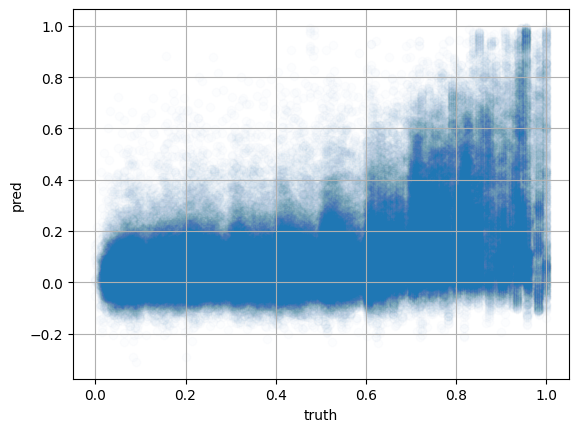

In [36]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_spec2vec, scores_spec2vec, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [38]:
original_tanimoto_spec2vec = tanimoto_spec2vec.copy()
original_scores_spec2vec=scores_spec2vec.copy()

In [40]:
tanimoto_spec2vec = [t for t in tanimoto_spec2vec if t is not None]
scores_spec2vec = [t for t in scores_spec2vec if t is not None]

In [41]:
tanimoto_spec2vec_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_spec2vec]
scores_spec2vec= [s if s>0 else 0 for s in scores_spec2vec ]

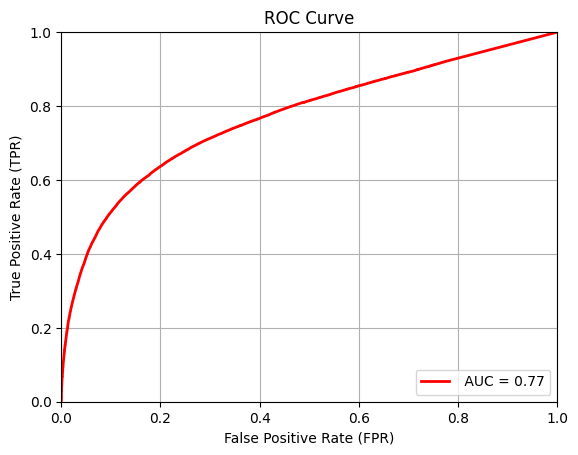

In [42]:
Plotting.plot_roc_curve(tanimoto_spec2vec_binary, 
                        scores_spec2vec)

In [43]:
spearman_spec2vec = spearmanr(tanimoto_spec2vec, scores_spec2vec)

## MS2DEEPSCORE

In [44]:
similarity_ms2 = MS2DeepScoreComparison.get_ms2deepscore_similarity(model_ms2d_file)

2024-02-23 09:48:24.752772: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-02-23 09:48:24.752806: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-02-23 09:48:24.752815: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-02-23 09:48:24.752865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-23 09:48:24.752900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
random_molecule_pairs_indexes = np.random.choice(range(0,len(molecule_pairs)), size=100)

In [46]:
random_molecule_pairs_indexes[0]

121958

In [47]:
import tensorflow as tf
from datetime import datetime
start =datetime.now()
with tf.device('/device:CPU:0'):
    tanimotos_ms2, scores_ms2 = MS2DeepScoreComparison.compute_ms2deepscore(molecule_pairs, 
                        random_molecule_pairs_indexes, 
                        original_spectrum_match_hash, 
                        target_hashes_subset,
                        similarity_ms2)
end = datetime.now()

print(f'total seconds {(end-start).total_seconds()}')

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step



2024-02-23 09:48:27.036777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166

1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3457.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2319.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 229.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2631.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2652.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4391.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1007.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3679.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4152.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3802.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2126.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2319.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2015.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2783.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2008.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2668.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1434.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2618.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4044.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3269.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4604.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1987.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3802.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 11ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 11ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.91it/s]

total seconds 5.02351


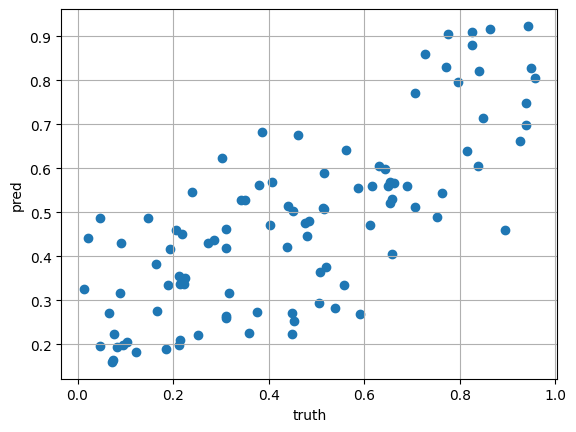

In [48]:
import matplotlib.pyplot as plt
plt.scatter(tanimotos_ms2, [s if s > 0 else 0 for s in scores_ms2], alpha=1)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [52]:
original_tanimotos_ms2 = tanimotos_ms2.copy()
original_scores_ms2=scores_ms2.copy()

In [53]:
tanimotos_ms2 = [t for t in tanimotos_ms2 if t is not None]
scores_ms2 = [t for t in scores_ms2 if t is not None]

In [54]:
tanimotos_ms2_binary= [1 if t>THRESHOLD_ANALOG else 0 for t in tanimotos_ms2]
scores_ms2=[s if s>0 else 0 for s in scores_ms2]

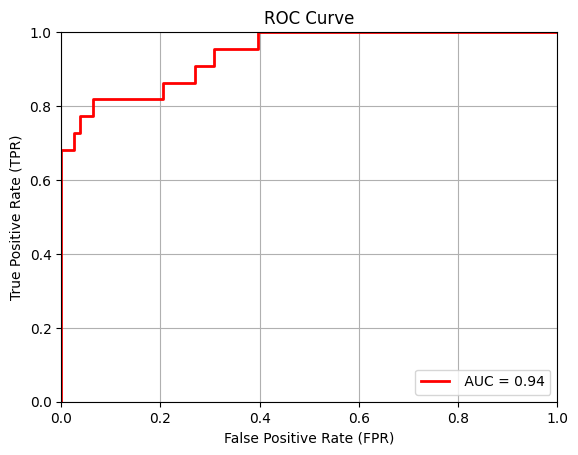

In [55]:

Plotting.plot_roc_curve(tanimotos_ms2_binary, scores_ms2)

In [56]:
a=5

In [57]:
spearman_ms2 = spearmanr(tanimotos_ms2, scores_ms2)

## Our model

In [58]:
from src.transformers.sklearn_model import SklearnModel

In [59]:
temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
                                      indexes_tani =molecule_pairs.indexes_tani)

In [60]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [61]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [62]:
#next(iter(dataloader_test))

In [63]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [64]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...


32486it [00:01, 21025.90it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32486it [00:00, 77306.40it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


Prediction has been called


Predicting: |                                                                                                 …

In [65]:
tanimoto_trans = [row[2] for row in molecule_pairs.indexes_tani]

In [66]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[s if s>0 else 0 for s in (scores_trans)]

In [67]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.8164817823281827, pvalue=0.0)

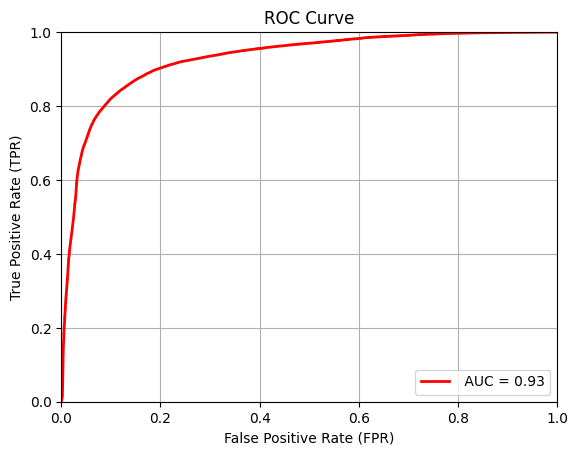

In [68]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

## Plot all results

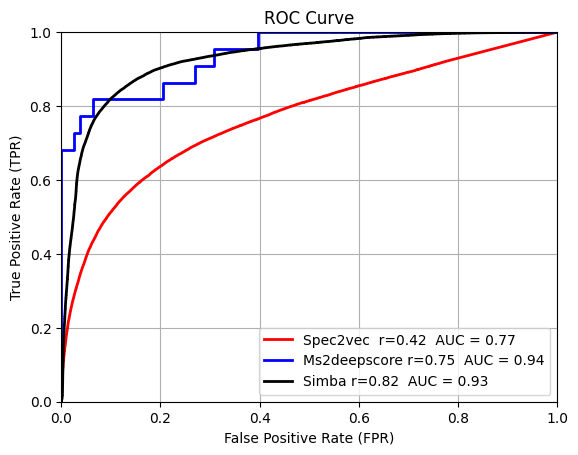

In [69]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_spec2vec_binary, tanimotos_ms2_binary, tanimoto_trans_binary],
                           y_scores_list=[scores_spec2vec, scores_ms2, scores_trans],
                           labels=[f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Simba r={spearman_trans[0]:.2f} '],
                           colors = ['r','b','k'])

## Save data

In [ ]:
## save spectrums to analyze
#with open('./spectrums_sent.pkl', 'wb') as f:
#    pickle.dump(original_spectrum_match_hash, f)

In [ ]:
#pairs = []
#for m in tqdm(molecule_pairs):
#            hash_0 = m.spectrum_object_0.spectrum_hash
#            hash_1 = m.spectrum_object_1.spectrum_hash

#            # get right spectra
#            index_0 = target_hashes_subset.index(hash_0)
#            index_1 = target_hashes_subset.index(hash_1)
#            pairs.append((index_0, index_1))

In [ ]:
## save pairs

In [ ]:
## save spectrums to analyze
#with open('./pairs_indexes.pkl', 'wb') as f:
#    pickle.dump(pairs, f)

## Compute modified cosine

In [73]:
from src.modified_cosine import ModCosine

In [75]:
modcos_similarity =ModCosine.get_mod_cosine()

In [149]:
tanimoto_modcos, scores_modcos= ModCosine.compute_scores_tanimoto(molecule_pairs, 
                                                                                original_spectrum_match_hash, 
                                                                               target_hashes_subset, 
                                                                               modcos_similarity)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185165/185165 [01:40<00:00, 1835.29it/s]


In [150]:
original_tanimoto_modcos = tanimoto_modcos.copy()
original_scores_modcos=scores_modcos.copy()

In [151]:
tanimoto_modcos = [t for t in tanimoto_modcos if t is not None]
scores_modcos = [t for t in scores_modcos if t is not None]

In [152]:
len(scores_modcos)

185158

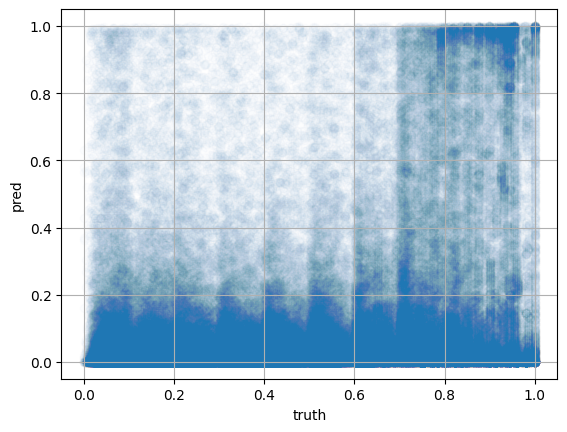

In [153]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_modcos, scores_modcos, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [154]:
tanimoto_modcos_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_modcos]
scores_modcos= [s if s>0 else 0 for s in scores_modcos ]

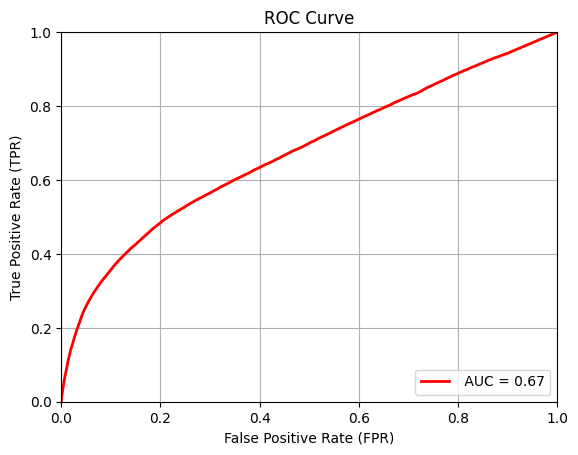

In [155]:
Plotting.plot_roc_curve(tanimoto_modcos_binary,scores_modcos)

In [156]:
len(scores_modcos)

185158

##  Save comparison

In [157]:
len(original_tanimoto_modcos)

185165

In [158]:
original_scores_modcos

[0.0,
 0.0012096807836851858,
 0.16755075567868874,
 0.08710684292627524,
 0.00162891616656258,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.23305338424577685,
 0.6827591354091765,
 0.9690650222205178,
 0.0011852579780658285,
 0.0030509350695712635,
 0.12385165785442838,
 0.0,
 0.0,
 0.15806637549289343,
 0.24287734583147683,
 0.029144860647236027,
 0.7659426868187728,
 0.0,
 0.1615846924246227,
 0.02977228448535462,
 0.008928613619907723,
 0.00018047369708304892,
 0.00305115061816503,
 0.02949247974889772,
 0.018427314401585532,
 0.006266134109124322,
 0.1566115610968348,
 0.013500479099248345,
 0.01438747884225167,
 0.0028653610076599246,
 0.008166724281176738,
 0.6763109117749274,
 0.38301559087266995,
 0.09421281098383259,
 0.001123713128557609,
 0.0,
 0.00796037342558871,
 0.18022610360203095,
 0.0,
 0.018683917052183086,
 0.10551192540817368,
 0.02412590246166541,
 0.027531851665377933,
 0.28285421698774665,
 0.0,
 0.20724887443011372,
 0.00038077158833998

In [159]:
tanimoto_trans

[0.00975609756097561,
 0.023255813953488372,
 0.03642384105960265,
 0.025179856115107913,
 0.017412935323383085,
 0.040625,
 0.021052631578947368,
 0.07913669064748201,
 0.024509803921568627,
 0.018518518518518517,
 0.023076923076923078,
 0.008620689655172414,
 0.013544018058690745,
 0.02131782945736434,
 0.02028740490278952,
 0.019230769230769232,
 0.034482758620689655,
 0.2112676056338028,
 0.021052631578947368,
 0.009900990099009901,
 0.038338658146964855,
 0.0353356890459364,
 0.04276315789473684,
 0.029082774049217,
 0.028925619834710745,
 0.01669195751138088,
 0.0625,
 0.44,
 0.022556390977443608,
 0.0,
 0.5641025641025641,
 0.005338078291814947,
 0.05181347150259067,
 0.09322033898305085,
 0.03526448362720403,
 0.030434782608695653,
 0.04426559356136821,
 0.012658227848101266,
 0.03684210526315789,
 0.06172839506172839,
 0.03861003861003861,
 0.012121212121212121,
 0.034782608695652174,
 0.03592814371257485,
 0.020942408376963352,
 0.012216404886561954,
 0.007936507936507936,
 0

In [160]:
scores_trans

[0.3943394720554352,
 0.1279943734407425,
 0.11943557858467102,
 0.10798540711402893,
 0.06399382650852203,
 0.10947638750076294,
 0.32698771357536316,
 0.12324367463588715,
 0.17498964071273804,
 0.12431283295154572,
 0.0645519495010376,
 0.08036106079816818,
 0.061134226620197296,
 0.046073008328676224,
 0.05204671621322632,
 0.046073008328676224,
 0.09240847080945969,
 0.7793803811073303,
 0.2923121154308319,
 0.11751681566238403,
 0.046073008328676224,
 0.046073008328676224,
 0.046073008328676224,
 0.13969288766384125,
 0.12655772268772125,
 0.08103524148464203,
 0.13339215517044067,
 0.22885216772556305,
 0.11522208154201508,
 0.949688732624054,
 1.0254236459732056,
 0.14049150049686432,
 0.1263463944196701,
 0.10382258892059326,
 0.05405707657337189,
 0.046073008328676224,
 0.1100492924451828,
 1.0196620225906372,
 0.14276158809661865,
 0.06393790245056152,
 0.16327856481075287,
 0.1320357769727707,
 1.0225474834442139,
 0.9943454265594482,
 0.10045430809259415,
 0.04607300832867

In [161]:
smiles = [(m.smiles_0, m.smiles_1) for m in molecule_pairs]

In [162]:
from rdkit import Chem

In [163]:
smiles = [(Chem.CanonSmiles(s[0]),Chem.CanonSmiles(s[1])) for s in smiles]

In [164]:
results= [(s[0],s[1],t, modcos, simba, ) for s,t,modcos,simba,  in zip(smiles, tanimoto_trans, original_scores_modcos, scores_trans)]

In [165]:
results = [r for r in results if r[3] is not None]

In [166]:
len(results)

185158

In [167]:
# Define the file path
file_path = 'comparison_table.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over the list of tuples
    file.write(f'smiles1, smiles2,tanimoto, mod_cosine, simba,\n')
    for tuple_item in results:
        # Convert the tuple to a string and write it as a line in the file
        file.write(f'{tuple_item[0]}, {tuple_item[1]},{tuple_item[2]}, {tuple_item[3]},{tuple_item[4]},\n')

In [ ]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_modcos, tanimoto_trans_binary],
                           y_scores_list=[scores_modcos, scores_trans],
                           labels=[f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Simba'],
                           colors = ['r','b','k'])